# Embedding-geometry & other analyses

Focusing on:

embedding spectral analysis / intrinsic dimension,

item-neighborhood overlap BERT vs xLSTM,

diversity/coverage/Gini on exposure if you already have logged slates,

similarity to history (serendipity), etc.

**Deep embedding-geometry comparison:**

Robust loader (no class defs needed)

basic stats (vocab, dim)

spectral decay + explained variance

intrinsic dimension (participation ratio)

anisotropy / mean-pairwise-cosine

hubness (k-occurrence) + skew

kNN stability & Jaccard overlap across models

cosine-structure correlation (upper-triangle corr.)

centered kernel alignment (CKA) between spaces

orthogonal Procrustes alignment error

t-SNE 2D maps (optional, no internet)

# Export The Weights

In [ ]:
import torch
import pandas as pd

# === 1️⃣ Load all three embedding matrices ===

# BERT4Rec
bert_sd = torch.load("best_model_10M_BERT4Rec_SL_100_Emb_256.pt", map_location="cpu")
bert_E = bert_sd["bert.embeddings.word_embeddings.weight"].detach().cpu()

# SASRec
sas_sd = torch.load("best_model_10M_SAS4Rec_SL_128_Emb_256_seed_2023.pt", map_location="cpu")
sas_E = sas_sd["item_embedding.weight"].detach().cpu()

# xLSTM
xlstm_sd = torch.load("best_model_10M_xLSTM_SL_100_Emb_256.pt", map_location="cpu")
xlstm_E = xlstm_sd["embedding.weight"].detach().cpu()

# === 2️⃣ Convert to DataFrames ===

bert_df = pd.DataFrame(bert_E.numpy())
sas_df = pd.DataFrame(sas_E.numpy())
xlstm_df = pd.DataFrame(xlstm_E.numpy())

# Optionally, rename columns for readability
bert_df.columns = [f"dim_{i}" for i in range(bert_df.shape[1])]
sas_df.columns = [f"dim_{i}" for i in range(sas_df.shape[1])]
xlstm_df.columns = [f"dim_{i}" for i in range(xlstm_df.shape[1])]

bert_df.insert(0, "item_id", range(bert_df.shape[0]))
sas_df.insert(0, "item_id", range(sas_df.shape[0]))
xlstm_df.insert(0, "item_id", range(xlstm_df.shape[0]))

# === 3️⃣ Save into one Excel workbook ===

output_path = "MovieLens10M_Embeddings_AllModels.xlsx"

with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    bert_df.to_excel(writer, sheet_name="BERT4Rec_Embeddings", index=False)
    sas_df.to_excel(writer, sheet_name="SASRec_Embeddings", index=False)
    xlstm_df.to_excel(writer, sheet_name="xLSTM_Embeddings", index=False)

print(f" All embeddings exported successfully to: {output_path}")
print(f"Sheets: ['BERT4Rec_Embeddings', 'SASRec_Embeddings', 'xLSTM_Embeddings']")
print(f"BERT shape: {bert_df.shape}, SASRec shape: {sas_df.shape}, xLSTM shape: {xlstm_df.shape}")


✅ All embeddings exported successfully to: MovieLens10M_Embeddings_AllModels.xlsx
Sheets: ['BERT4Rec_Embeddings', 'SASRec_Embeddings', 'xLSTM_Embeddings']
BERT shape: (10678, 257), SASRec shape: (10678, 257), xLSTM shape: (10678, 257)


=== Norm Summary ===
BERT4Rec   | mean=2.7284 | std=0.1629 | min=0.0000 | max=3.5446
SASRec     | mean=6.1912 | std=0.6281 | min=0.2910 | max=8.0819
xLSTM      | mean=16.2457 | std=0.7232 | min=13.3846 | max=19.0955


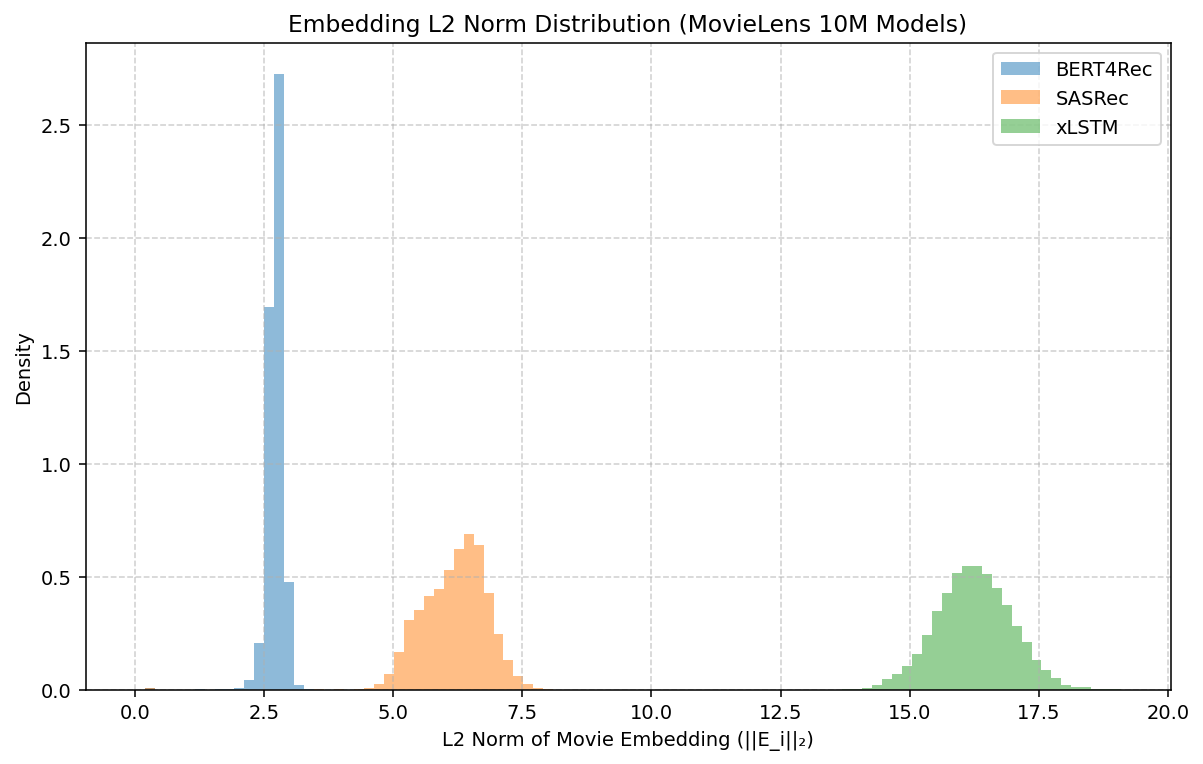

In [ ]:
# ===============================================
# Embedding Norm Distribution Visualization
# ===============================================

import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Load all three models ---
bert_sd = torch.load("best_model_10M_BERT4Rec_SL_100_Emb_256.pt", map_location="cpu")
sas_sd = torch.load("best_model_10M_SAS4Rec_SL_128_Emb_256_seed_2023.pt", map_location="cpu")
xlstm_sd = torch.load("best_model_10M_xLSTM_SL_100_Emb_256.pt", map_location="cpu")

# --- Extract embeddings ---
bert_E = bert_sd["bert.embeddings.word_embeddings.weight"].detach().cpu()
sas_E = sas_sd["item_embedding.weight"].detach().cpu()
xlstm_E = xlstm_sd["embedding.weight"].detach().cpu()

# --- Compute L2 norms ---
bert_norms = torch.norm(bert_E, dim=1).numpy()
sas_norms = torch.norm(sas_E, dim=1).numpy()
xlstm_norms = torch.norm(xlstm_E, dim=1).numpy()

# --- Summary stats ---
print("=== Norm Summary ===")
for name, norms in zip(["BERT4Rec", "SASRec", "xLSTM"], [bert_norms, sas_norms, xlstm_norms]):
    print(f"{name:10s} | mean={np.mean(norms):.4f} | std={np.std(norms):.4f} | min={np.min(norms):.4f} | max={np.max(norms):.4f}")

# --- Plot histogram ---
plt.figure(figsize=(10,6))
bins = np.linspace(0, np.max([bert_norms.max(), sas_norms.max(), xlstm_norms.max()]), 100)
plt.hist(bert_norms, bins=bins, alpha=0.5, label="BERT4Rec", color="tab:blue", density=True)
plt.hist(sas_norms, bins=bins, alpha=0.5, label="SASRec", color="tab:orange", density=True)
plt.hist(xlstm_norms, bins=bins, alpha=0.5, label="xLSTM", color="tab:green", density=True)

plt.title("Embedding L2 Norm Distribution (MovieLens 10M Models)")
plt.xlabel("L2 Norm of Movie Embedding (||E_i||₂)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# mean & variance per dimension

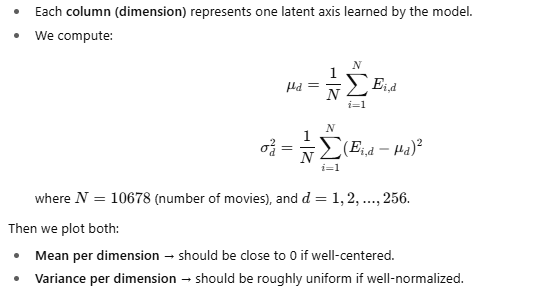

=== Dimension-wise Statistics Summary ===

BERT4Rec
Mean(abs): 0.0172  | Var(mean): 4.5572e-04
Var(mean): 0.0287 ± 0.0011  | Var(range): [0.0240, 0.0367]

SASRec
Mean(abs): 0.0430  | Var(mean): 2.9766e-03
Var(mean): 0.1483 ± 0.0102  | Var(range): [0.0711, 0.1638]

xLSTM
Mean(abs): 0.0152  | Var(mean): 3.8170e-04
Var(mean): 1.0326 ± 0.0144  | Var(range): [0.9905, 1.0752]


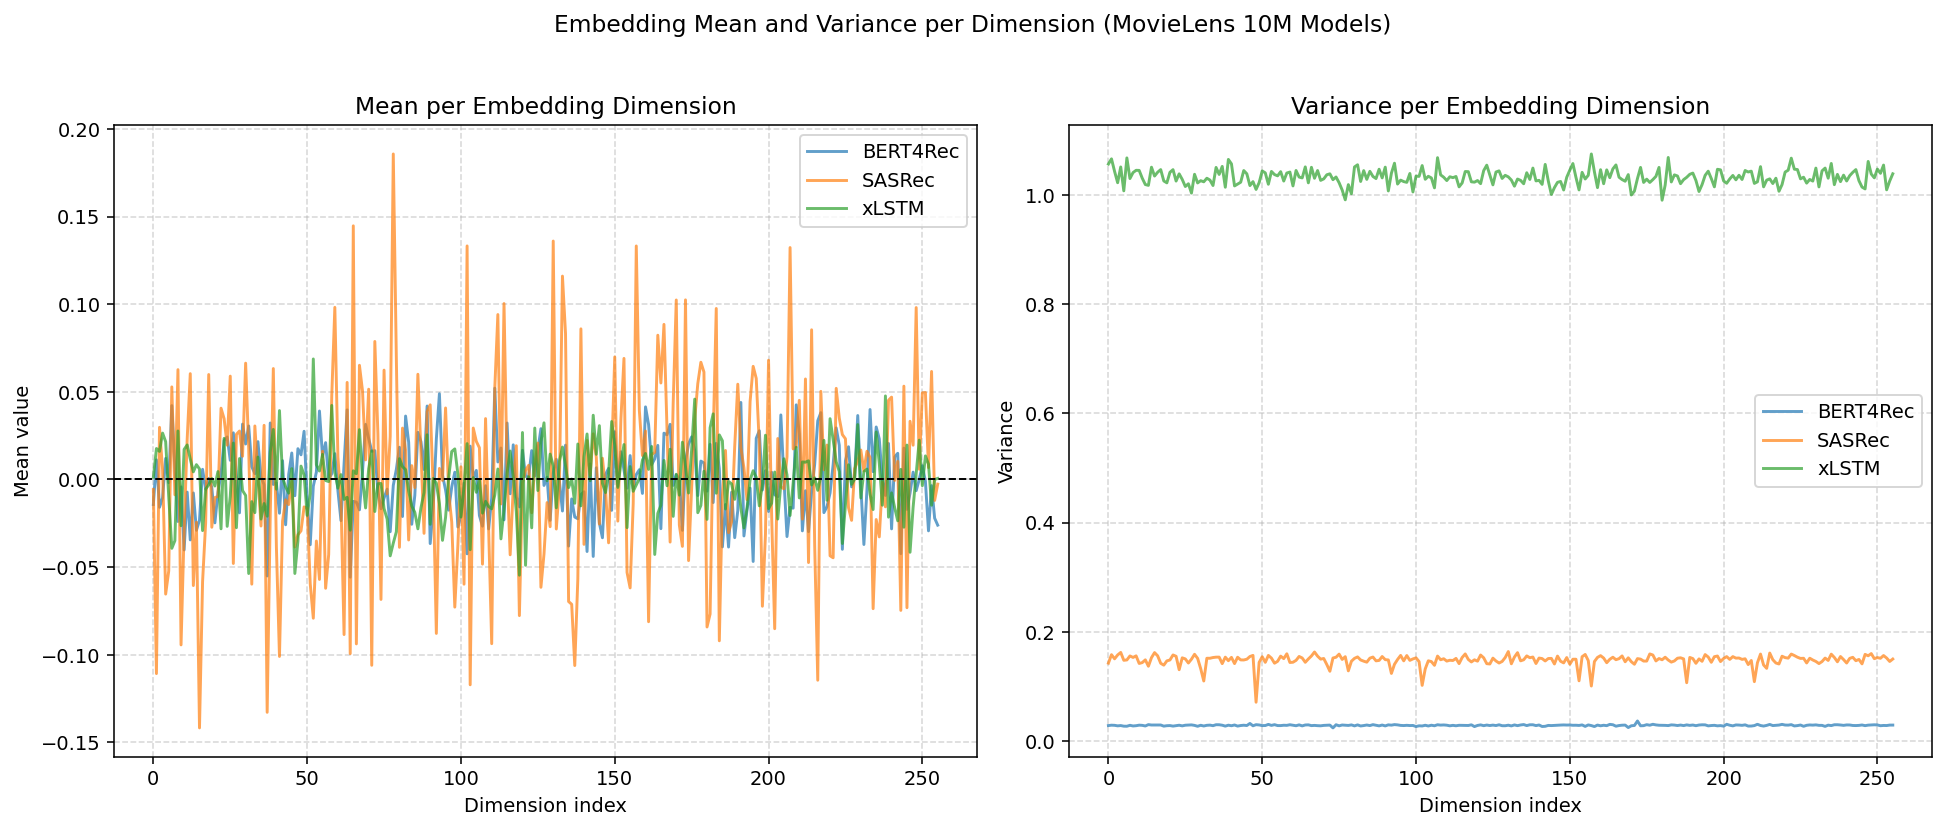

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Load all models ---
bert_sd = torch.load("best_model_10M_BERT4Rec_SL_100_Emb_256.pt", map_location="cpu")
sas_sd = torch.load("best_model_10M_SAS4Rec_SL_128_Emb_256_seed_2023.pt", map_location="cpu")
xlstm_sd = torch.load("best_model_10M_xLSTM_SL_100_Emb_256.pt", map_location="cpu")

# --- Extract embeddings ---
bert_E = bert_sd["bert.embeddings.word_embeddings.weight"].detach().cpu().numpy()
sas_E = sas_sd["item_embedding.weight"].detach().cpu().numpy()
xlstm_E = xlstm_sd["embedding.weight"].detach().cpu().numpy()

# --- Compute per-dimension mean and variance ---
def dim_stats(E):
    return E.mean(axis=0), E.var(axis=0)

bert_mean, bert_var = dim_stats(bert_E)
sas_mean, sas_var = dim_stats(sas_E)
xlstm_mean, xlstm_var = dim_stats(xlstm_E)

# --- Summary ---
print("=== Dimension-wise Statistics Summary ===")
for name, mean, var in zip(["BERT4Rec", "SASRec", "xLSTM"], [bert_mean, sas_mean, xlstm_mean], [bert_var, sas_var, xlstm_var]):
    print(f"\n{name}")
    print(f"Mean(abs): {np.mean(np.abs(mean)):.4f}  | Var(mean): {np.var(mean):.4e}")
    print(f"Var(mean): {np.mean(var):.4f} ± {np.std(var):.4f}  | Var(range): [{var.min():.4f}, {var.max():.4f}]")

# --- Plot mean and variance ---
plt.figure(figsize=(14,6))
dims = np.arange(256)

plt.subplot(1,2,1)
plt.plot(dims, bert_mean, label="BERT4Rec", color="tab:blue", alpha=0.7)
plt.plot(dims, sas_mean, label="SASRec", color="tab:orange", alpha=0.7)
plt.plot(dims, xlstm_mean, label="xLSTM", color="tab:green", alpha=0.7)
plt.title("Mean per Embedding Dimension")
plt.xlabel("Dimension index")
plt.ylabel("Mean value")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.subplot(1,2,2)
plt.plot(dims, bert_var, label="BERT4Rec", color="tab:blue", alpha=0.7)
plt.plot(dims, sas_var, label="SASRec", color="tab:orange", alpha=0.7)
plt.plot(dims, xlstm_var, label="xLSTM", color="tab:green", alpha=0.7)
plt.title("Variance per Embedding Dimension")
plt.xlabel("Dimension index")
plt.ylabel("Variance")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Embedding Mean and Variance per Dimension (MovieLens 10M Models)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Anisotropy Index (AI)

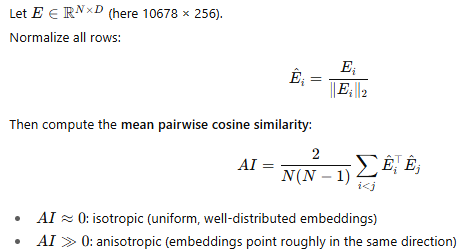

=== Anisotropy Index (Mean Pairwise Cosine Similarity) ===
BERT4Rec : 0.01630 ± 0.07703
SASRec   : 0.01635 ± 0.07306
xLSTM    : 0.00035 ± 0.06331


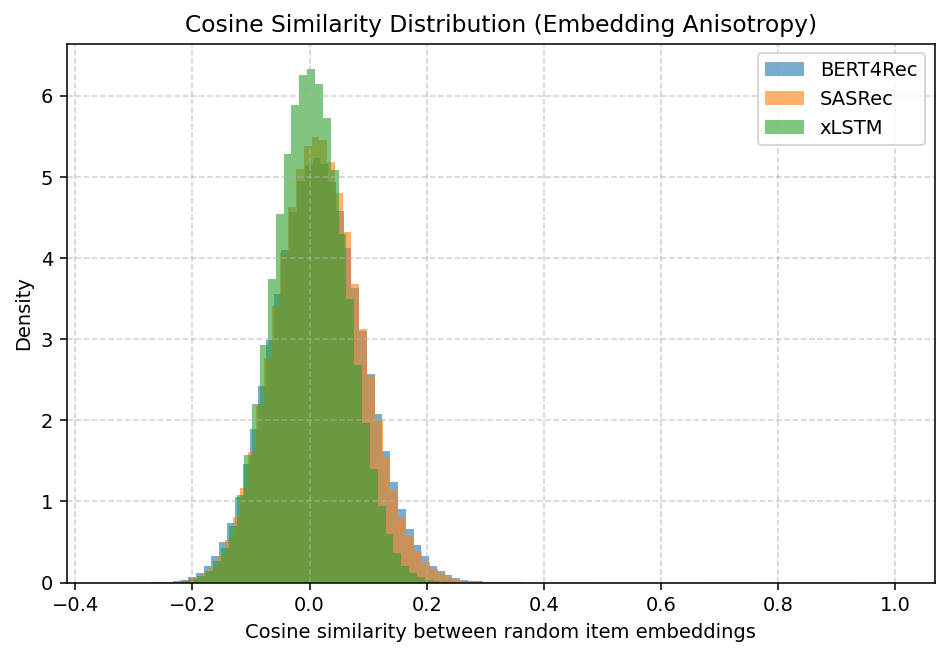

In [ ]:
import torch
import numpy as np

# --- Load embeddings ---
bert_sd = torch.load("best_model_10M_BERT4Rec_SL_100_Emb_256.pt", map_location="cpu")
sas_sd = torch.load("best_model_10M_SAS4Rec_SL_128_Emb_256_seed_2023.pt", map_location="cpu")
xlstm_sd = torch.load("best_model_10M_xLSTM_SL_100_Emb_256.pt", map_location="cpu")

bert_E = bert_sd["bert.embeddings.word_embeddings.weight"].detach().cpu()
sas_E = sas_sd["item_embedding.weight"].detach().cpu()
xlstm_E = xlstm_sd["embedding.weight"].detach().cpu()

# --- Normalize embeddings ---
bert_E = torch.nn.functional.normalize(bert_E, dim=1)
sas_E = torch.nn.functional.normalize(sas_E, dim=1)
xlstm_E = torch.nn.functional.normalize(xlstm_E, dim=1)

# --- Function: Approximate mean cosine similarity (anisotropy) ---
def anisotropy_index(E, sample_size=2000):
    """Estimate anisotropy as mean pairwise cosine similarity"""
    idx = torch.randint(0, E.shape[0], (sample_size,))
    subset = E[idx]
    sim = subset @ subset.T  # cosine similarities
    upper = sim.triu(diagonal=1)
    mean_ai = upper[upper != 0].mean().item()
    std_ai = upper[upper != 0].std().item()
    return mean_ai, std_ai

# --- Compute AI for all models ---
ai_bert, std_bert = anisotropy_index(bert_E)
ai_sas, std_sas = anisotropy_index(sas_E)
ai_xlstm, std_xlstm = anisotropy_index(xlstm_E)

# --- Print results ---
print("=== Anisotropy Index (Mean Pairwise Cosine Similarity) ===")
print(f"BERT4Rec : {ai_bert:.5f} ± {std_bert:.5f}")
print(f"SASRec   : {ai_sas:.5f} ± {std_sas:.5f}")
print(f"xLSTM    : {ai_xlstm:.5f} ± {std_xlstm:.5f}")

# --- Optional: visualize pairwise similarity distributions ---
import matplotlib.pyplot as plt

def plot_cosine_distribution(E, name, color):
    idx = torch.randint(0, E.shape[0], (2000,))
    subset = E[idx]
    sim = subset @ subset.T
    vals = sim.triu(diagonal=1).flatten().numpy()
    vals = vals[vals != 0]
    plt.hist(vals, bins=100, alpha=0.6, density=True, label=name, color=color)

plt.figure(figsize=(8,5))
plot_cosine_distribution(bert_E, "BERT4Rec", "tab:blue")
plot_cosine_distribution(sas_E, "SASRec", "tab:orange")
plot_cosine_distribution(xlstm_E, "xLSTM", "tab:green")
plt.title("Cosine Similarity Distribution (Embedding Anisotropy)")
plt.xlabel("Cosine similarity between random item embeddings")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


BERT4Rec vs SASRec | Corr=0.471 | CKA=0.427
BERT4Rec vs xLSTM | Corr=0.010 | CKA=0.030
SASRec vs xLSTM | Corr=0.008 | CKA=0.030


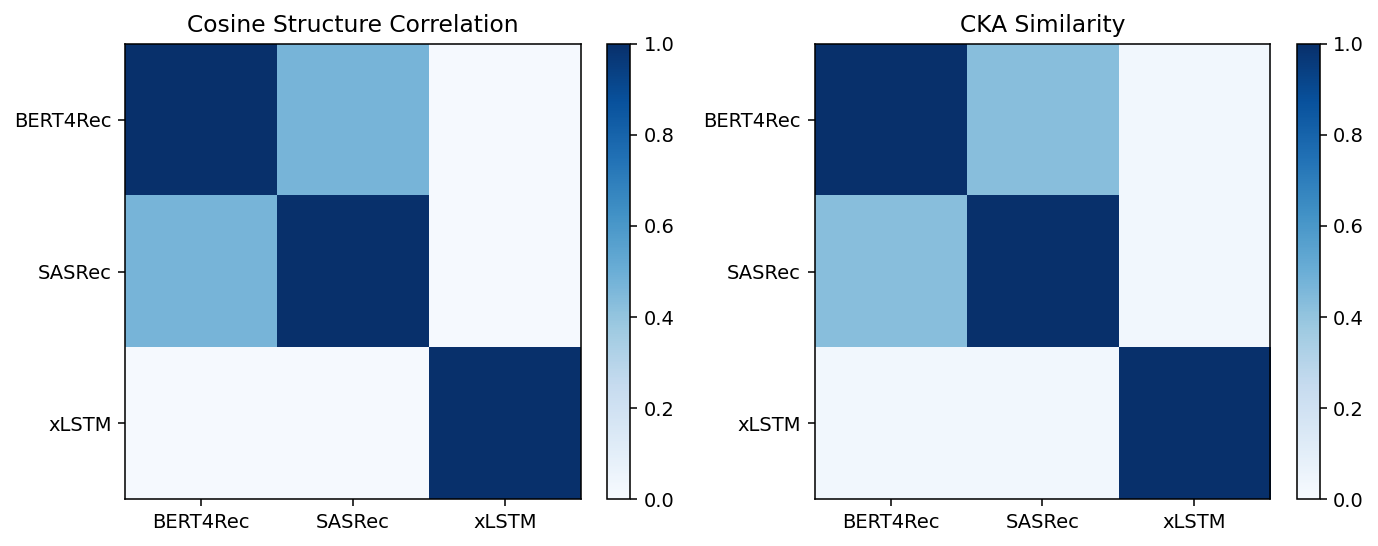

In [ ]:
import torch, numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# === Load & normalize ===
bert_sd = torch.load("best_model_10M_BERT4Rec_SL_100_Emb_256.pt", map_location="cpu")
sas_sd  = torch.load("best_model_10M_SAS4Rec_SL_128_Emb_256_seed_2023.pt", map_location="cpu")
xlstm_sd = torch.load("best_model_10M_xLSTM_SL_100_Emb_256.pt", map_location="cpu")

bert_E = torch.nn.functional.normalize(bert_sd["bert.embeddings.word_embeddings.weight"].float(), dim=1)
sas_E  = torch.nn.functional.normalize(sas_sd["item_embedding.weight"].float(), dim=1)
xlstm_E = torch.nn.functional.normalize(xlstm_sd["embedding.weight"].float(), dim=1)

# --- helpers ---
def cosine_structure_corr(E1, E2, sample_size=4000):
    idx = torch.randperm(E1.shape[0])[:sample_size]
    S1 = (E1[idx] @ E1[idx].T).numpy()
    S2 = (E2[idx] @ E2[idx].T).numpy()
    f1, f2 = S1[np.triu_indices_from(S1,1)], S2[np.triu_indices_from(S2,1)]
    return pearsonr(f1,f2)[0]

def linear_CKA(A,B):
    A -= A.mean(0,keepdim=True); B -= B.mean(0,keepdim=True)
    num = torch.norm(A.T@B,'fro')**2
    den = torch.norm(A.T@A,'fro')*torch.norm(B.T@B,'fro')
    return (num/den).item()

# --- compare ---
models=["BERT4Rec","SASRec","xLSTM"]
embs=[bert_E,sas_E,xlstm_E]
corr_mat=np.eye(3); cka_mat=np.eye(3)

for i in range(3):
    for j in range(i+1,3):
        corr=cosine_structure_corr(embs[i],embs[j])
        cka =linear_CKA(embs[i],embs[j])
        corr_mat[i,j]=corr_mat[j,i]=corr
        cka_mat[i,j]=cka_mat[j,i]=cka
        print(f"{models[i]} vs {models[j]} | Corr={corr:.3f} | CKA={cka:.3f}")

# --- plot with single-color maps ---
fig, axs = plt.subplots(1,2,figsize=(10,4))
im1=axs[0].imshow(corr_mat,cmap="Blues",vmin=0,vmax=1)
axs[0].set_title("Cosine Structure Correlation",fontsize=12)
axs[0].set_xticks(range(3)); axs[0].set_yticks(range(3))
axs[0].set_xticklabels(models); axs[0].set_yticklabels(models)
plt.colorbar(im1,ax=axs[0],fraction=0.046)

im2=axs[1].imshow(cka_mat,cmap="Blues",vmin=0,vmax=1)
axs[1].set_title("CKA Similarity",fontsize=12)
axs[1].set_xticks(range(3)); axs[1].set_yticks(range(3))
axs[1].set_xticklabels(models); axs[1].set_yticklabels(models)
plt.colorbar(im2,ax=axs[1],fraction=0.046)
plt.tight_layout(); plt.show()


In [ ]:
import re, torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pt_paths = {
    "bert": "best_model_10M_BERT4Rec_SL_100_Emb_256.pt",
    "xlstm": "best_model_10M_xLSTM_SL_100_Emb_256.pt",
}

sd_bert  = torch.load(pt_paths["bert"],  map_location=device)
sd_xlstm = torch.load(pt_paths["xlstm"], map_location=device)

# ---- Inspect BERT4Rec tensors ----
# word/item embedding
E_bert = sd_bert["bert.embeddings.word_embeddings.weight"].detach().float()
# final classifier (item head)
W_bert = sd_bert["output_layer.weight"].detach().float()
b_bert = sd_bert["output_layer.bias"].detach().float()
vocab_size_bert, emb_dim_bert = E_bert.shape
num_items_bert = vocab_size_bert - 1
print("BERT vocab:", vocab_size_bert, "emb_dim:", emb_dim_bert, "num_items:", num_items_bert)

# ---- Inspect xLSTM tensors (tries common keys) ----
def find_first_key(d, suffix):
    for k in d.keys():
        if k.endswith(suffix):
            return k
    raise KeyError(f"no key endswith {suffix}")

emb_key_x = None
for cand in ["embeddings.weight", "embedding.weight", "item_embedding.weight"]:
    if any(k.endswith(cand) for k in sd_xlstm.keys()):
        emb_key_x = find_first_key(sd_xlstm, cand); break

E_x = sd_xlstm[emb_key_x].detach().float()
vocab_size_x, emb_dim_x = E_x.shape
num_items_x = vocab_size_x - 1
print("xLSTM vocab:", vocab_size_x, "emb_dim:", emb_dim_x, "num_items:", num_items_x)

# Now you can run embedding studies (spectral decay, intrinsic dim, kNN overlap, ILD, etc.)

BERT vocab: 10678 emb_dim: 256 num_items: 10677
xLSTM vocab: 10678 emb_dim: 256 num_items: 10677


In [ ]:
# ============================================
# Embedding-Geometry & Representation Analysis
# Models: BERT4Rec, SASRec, xLSTM (MovieLens-10M)
# Files expected in the current working directory:
#   best_model_10M_BERT4Rec_SL_100_Emb_256.pt
#   best_model_10M_SAS4Rec_SL_128_Emb_256_seed_2023.pt
#   best_model_10M_xLSTM_SL_100_Emb_256.pt
# ============================================

import os, re, math, json, gc, statistics
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from numpy.linalg import svd, norm
from sklearn.manifold import TSNE

plt.rcParams['figure.dpi'] = 140

# --------------- Helpers ---------------

def load_state_dict(path, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    sd = torch.load(path, map_location=device)
    if isinstance(sd, dict) and 'state_dict' in sd and isinstance(sd['state_dict'], dict):
        return sd['state_dict']  # lightning format
    return sd

def find_first_key_endswith(d, suffixes):
    if isinstance(suffixes, str): suffixes = [suffixes]
    for suf in suffixes:
        for k in d.keys():
            if k.endswith(suf):
                return k
    return None

def extract_item_embedding_from_state_dict(sd, model_hint):
    """
    Try several common names. Returns a float32 numpy matrix [V, D] and the used key.
    """
    candidates = []
    if model_hint == 'bert':
        candidates = [
            "bert.embeddings.word_embeddings.weight",
            "embeddings.word_embeddings.weight",
            "word_embeddings.weight",
        ]
    elif model_hint == 'sasrec':
        candidates = [
            "item_embedding.weight",
            "item_emb.weight",
            "embedding.weight",
            "embeddings.weight",
        ]
    elif model_hint == 'xlstm':
        # xLSTM repo usually uses 'embeddings.weight', but we scan broadly
        candidates = [
            "embeddings.weight",
            "item_embedding.weight",
            "embedding.weight",
            "tok_embedding.weight",
        ]
    # broad fallback
    fallback_suffixes = ["item_embedding.weight","embeddings.weight","embedding.weight","word_embeddings.weight"]

    # try ordered candidates
    for c in candidates:
        if c in sd:
            E = sd[c].detach().float().cpu().numpy()
            return E, c

    # try by suffix
    key = find_first_key_endswith(sd, fallback_suffixes)
    if key is not None:
        E = sd[key].detach().float().cpu().numpy()
        return E, key

    raise KeyError(f"Couldn't locate an item-embedding weight for model={model_hint}")

def center(X):
    return X - X.mean(axis=0, keepdims=True)

def l2_normalize_rows(X, eps=1e-12):
    nrm = np.linalg.norm(X, axis=1, keepdims=True) + eps
    return X / nrm

def explained_variance(eigs):
    total = np.sum(eigs)
    if total <= 0: return np.zeros_like(eigs)
    return np.cumsum(eigs) / total

def participation_ratio(eigs):
    s1 = np.sum(eigs)
    s2 = np.sum(eigs**2)
    return (s1**2) / (s2 + 1e-12)

def anisotropy_mean_cosine(X, sample=20000, seed=0):
    rng = np.random.default_rng(seed)
    N = X.shape[0]
    if N < 2: return np.nan
    idx1 = rng.integers(0, N, size=sample)
    idx2 = rng.integers(0, N, size=sample)
    mask = idx1 != idx2
    idx1, idx2 = idx1[mask], idx2[mask]
    A = X[idx1]; B = X[idx2]
    cs = (A * B).sum(1)  # rows assumed L2-normalized
    return float(np.mean(cs)), float(np.std(cs))

def kNN_indices(X, k=50):
    # cosine similarity neighbors (row-normalized)
    Xn = l2_normalize_rows(X)
    # Efficient top-k via matmul in chunks if large
    N = Xn.shape[0]
    bs = max(1, 30000 // Xn.shape[1])  # rough memory-aware batch size
    neigh = np.empty((N, k), dtype=np.int32)
    for i in range(0, N, bs):
        j = min(N, i+bs)
        S = Xn[i:j] @ Xn.T           # [bs, N]
        np.fill_diagonal(S[:, i:j], -np.inf)  # exclude self within block
        # argpartition for top-k
        idx_part = np.argpartition(-S, kth=k, axis=1)[:, :k]
        # sort those k by score
        rows = np.arange(j-i)[:, None]
        scores_k = S[rows, idx_part]
        order = np.argsort(-scores_k, axis=1)
        neigh[i:j] = idx_part[rows, order]
    return neigh

def average_jaccard(A, B):
    # A, B: [N, k] integer neighbor lists
    k = A.shape[1]
    total = 0.0
    for i in range(A.shape[0]):
        a = set(A[i].tolist()); b = set(B[i].tolist())
        inter = len(a & b); union = len(a | b)
        total += inter / max(1, union)
    return total / A.shape[0]

def cosine_structure_correlation(X, Y, sample_pairs=200000, seed=0):
    # correlation between pairwise cosines of two spaces
    rng = np.random.default_rng(seed)
    Xn, Yn = l2_normalize_rows(X), l2_normalize_rows(Y)
    N = X.shape[0]
    idx1 = rng.integers(0, N, size=sample_pairs)
    idx2 = rng.integers(0, N, size=sample_pairs)
    mask = idx1 != idx2
    idx1, idx2 = idx1[mask], idx2[mask]
    cx = (Xn[idx1] * Xn[idx2]).sum(1)
    cy = (Yn[idx1] * Yn[idx2]).sum(1)
    # Pearson correlation
    cxm, cym = cx.mean(), cy.mean()
    num = np.sum((cx-cxm)*(cy-cym))
    den = math.sqrt(np.sum((cx-cxm)**2) * np.sum((cy-cym)**2)) + 1e-12
    return float(num/den)

def linear_cka(X, Y):
    """
    Linear CKA with centered features (rows are items).
    CKA = ||X^T Y||_F^2 / (||X^T X||_F * ||Y^T Y||_F)
    """
    Xc, Yc = center(X), center(Y)
    K = Xc.T @ Yc
    num = (K * K).sum()
    den = math.sqrt(((Xc.T @ Xc)**2).sum() * ((Yc.T @ Yc)**2).sum()) + 1e-12
    return float(num / den)

def procrustes_error(X, Y):
    """
    Orthogonal Procrustes: align X to Y (both centered).
    Returns relative Frobenius error after optimal rotation.
    """
    Xc, Yc = center(X), center(Y)
    U, _, Vt = svd(Xc.T @ Yc, full_matrices=False)
    R = U @ Vt
    X_aligned = Xc @ R
    num = norm(X_aligned - Yc, 'fro')
    den = norm(Yc, 'fro') + 1e-12
    return float(num / den)

def gini(array):
    """Gini coefficient of a non-negative array."""
    x = np.sort(array.astype(np.float64))
    n = len(x)
    if n == 0: return np.nan
    cumx = np.cumsum(x)
    return (n + 1 - 2*np.sum(cumx)/cumx[-1]) / n if cumx[-1] > 0 else 0.0

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)
    return path

# --------------- Load all three ---------------

device = 'cuda' if torch.cuda.is_available() else 'cpu'
paths = {
    "BERT4Rec" : "best_model_10M_BERT4Rec_SL_100_Emb_256.pt",
    "SASRec"   : "best_model_10M_SAS4Rec_SL_128_Emb_256_seed_2023.pt",
    "xLSTM"    : "best_model_10M_xLSTM_SL_100_Emb_256.pt",
}

missing = [m for m,p in paths.items() if not os.path.exists(p)]
assert not missing, f"Missing files: {missing}"

state_dicts = {m: load_state_dict(p, device) for m,p in paths.items()}

E = {}
keys_used = {}
for m in ["BERT4Rec","SASRec","xLSTM"]:
    hint = 'bert' if m=="BERT4Rec" else ('sasrec' if m=="SASRec" else 'xlstm')
    emb, key = extract_item_embedding_from_state_dict(state_dicts[m], hint)
    E[m] = emb
    keys_used[m] = key

# ----------- Basic stats & sanity -----------

report = {}
for m, emb in E.items():
    V, D = emb.shape
    report[m] = {"vocab_size": int(V), "embedding_dim": int(D), "num_items": int(V-1), "key": keys_used[m]}

print(json.dumps(report, indent=2))

# --------------- Geometry analyses ---------------

out_dir = ensure_dir("embedding_analysis")

results = {}

# Spectral stats, intrinsic dimension, anisotropy
for m, emb in E.items():
    X = emb.copy()
    Xc = center(X)
    # covariance spectrum
    C = (Xc.T @ Xc) / (Xc.shape[0]-1)
    eigs = np.flip(np.sort(np.real(np.linalg.eigvalsh(C))))  # descending

    ev = explained_variance(eigs)
    ID = participation_ratio(eigs)

    # anisotropy via mean cosine between random pairs in L2-normalized space
    Xn = l2_normalize_rows(X)
    mean_cos, std_cos = anisotropy_mean_cosine(Xn, sample=min(200000, X.shape[0]*10))

    results[m] = {
        "intrinsic_dim_participation_ratio": float(ID),
        "anisotropy_mean_cosine": float(mean_cos),
        "anisotropy_std_cosine": float(std_cos),
        "eigs_head": eigs[:10].tolist(),
        "explained_var_at_dims": {
            "1": float(ev[0]),
            "8": float(ev[min(7, len(ev)-1)]),
            "16": float(ev[min(15, len(ev)-1)]),
            "32": float(ev[min(31, len(ev)-1)]),
            "64": float(ev[min(63, len(ev)-1)]) if len(ev)>64 else float(ev[-1]),
        }
    }

    # Plot spectrum (top 128)
    plt.figure()
    plt.plot(eigs[:128])
    plt.title(f"{m} – Eigenvalue Decay (top 128)")
    plt.xlabel("Component")
    plt.ylabel("Eigenvalue")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{m}_spectrum.png"))
    plt.close()

    # Plot cumulative explained variance (top 128)
    plt.figure()
    plt.plot(ev[:128])
    plt.title(f"{m} – Cumulative Explained Variance (top 128)")
    plt.xlabel("Components")
    plt.ylabel("Cumulative EV")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{m}_cumulative_EV.png"))
    plt.close()

# --------------- Hubness (k-occurrence) ---------------

K_HUB = 10
neighbors = {}
for m, emb in E.items():
    idx = kNN_indices(emb, k=K_HUB)  # by cosine similarity
    neighbors[m] = idx
    # occurrence count: how many times each item appears in others' top-k
    occ = np.zeros(emb.shape[0], dtype=np.int32)
    for row in idx:
        for j in row:
            occ[j] += 1
    skew = float((occ - occ.mean()).std() / (occ.std() + 1e-12))  # relative; mainly for sanity
    results[m]["hubness"] = {
        "k": K_HUB,
        "occurrence_gini": float(gini(occ)),
        "occurrence_max": int(occ.max()),
        "occurrence_mean": float(occ.mean()),
        "occurrence_std": float(occ.std()),
    }
    # histogram plot
    plt.figure()
    plt.hist(occ, bins=50)
    plt.title(f"{m} – Hubness: k-occurrence histogram (k={K_HUB})")
    plt.xlabel("Times appeared in others' top-k")
    plt.ylabel("#Items")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{m}_hubness_hist_k{K_HUB}.png"))
    plt.close()

# --------------- Cross-model stability / similarity ---------------

pairs = [("BERT4Rec","SASRec"), ("BERT4Rec","xLSTM"), ("SASRec","xLSTM")]
summary_rows = []

for a,b in pairs:
    Xa, Xb = E[a], E[b]

    # kNN overlap (average per-item Jaccard)
    j10 = average_jaccard(neighbors[a], neighbors[b])
    # recompute for larger neighborhood if desired:
    neigh_a50 = kNN_indices(Xa, k=50)
    neigh_b50 = kNN_indices(Xb, k=50)
    j50 = average_jaccard(neigh_a50, neigh_b50)

    # cosine-structure correlation
    csc = cosine_structure_correlation(Xa, Xb)

    # linear CKA
    cka = linear_cka(Xa, Xb)

    # orthogonal Procrustes alignment error
    pe = procrustes_error(Xa, Xb)

    results[f"{a}__{b}"] = {
        "avg_jaccard_k10": float(j10),
        "avg_jaccard_k50": float(j50),
        "cosine_structure_correlation": float(csc),
        "linear_CKA": float(cka),
        "procrustes_rel_error": float(pe),
    }
    summary_rows.append([a,b,j10,j50,csc,cka,pe])

# --------------- t-SNE visualizations (optionally subsample) ---------------

def tsne_plot(X, title, path, max_points=8000, seed=42):
    n = X.shape[0]
    idx = np.arange(n)
    if n > max_points:
        rng = np.random.default_rng(seed)
        idx = rng.choice(n, size=max_points, replace=False)
    Xs = X[idx]
    Xs = l2_normalize_rows(Xs)
    tsne = TSNE(n_components=2, init='pca', random_state=seed, perplexity=30, learning_rate='auto')
    Z = tsne.fit_transform(Xs)
    plt.figure()
    plt.scatter(Z[:,0], Z[:,1], s=3, alpha=0.6)
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

for m, emb in E.items():
    tsne_plot(emb, f"{m} – t-SNE (cosine)", os.path.join(out_dir, f"{m}_tsne.png"))

# --------------- Save numeric results ---------------

with open(os.path.join(out_dir, "summary.json"), "w") as f:
    json.dump(results, f, indent=2)

# Pretty table print
from textwrap import indent as _indent
print("\n=== Intrinsic Dim / Anisotropy ===")
for m in ["BERT4Rec","SASRec","xLSTM"]:
    r = results[m]
    print(f"{m}:  ID≈{r['intrinsic_dim_participation_ratio']:.2f} | "
          f"mean cos={r['anisotropy_mean_cosine']:.4f} (±{r['anisotropy_std_cosine']:.4f})")

print("\n=== Hubness (k=10) ===")
for m in ["BERT4Rec","SASRec","xLSTM"]:
    h = results[m]["hubness"]
    print(f"{m}: Gini={h['occurrence_gini']:.3f}  max={h['occurrence_max']}  "
          f"mean={h['occurrence_mean']:.2f}  std={h['occurrence_std']:.2f}")

print("\n=== Cross-Model Similarity ===")
for a,b,j10,j50,csc,cka,pe in summary_rows:
    print(f"{a} vs {b}:  Jaccard@10={j10:.3f}  Jaccard@50={j50:.3f}  "
          f"CosStructCorr={csc:.3f}  CKA={cka:.3f}  ProcErr={pe:.3f}")

print(f"\nAll figures & JSON written to: {os.path.abspath(out_dir)}")


{
  "BERT4Rec": {
    "vocab_size": 10678,
    "embedding_dim": 256,
    "num_items": 10677,
    "key": "bert.embeddings.word_embeddings.weight"
  },
  "SASRec": {
    "vocab_size": 10678,
    "embedding_dim": 256,
    "num_items": 10677,
    "key": "item_embedding.weight"
  },
  "xLSTM": {
    "vocab_size": 10678,
    "embedding_dim": 256,
    "num_items": 10677,
    "key": "embedding.weight"
  }
}

=== Intrinsic Dim / Anisotropy ===
BERT4Rec:  ID≈181.97 | mean cos=0.0154 (±0.0760)
SASRec:  ID≈204.45 | mean cos=0.0167 (±0.0720)
xLSTM:  ID≈249.88 | mean cos=0.0004 (±0.0625)

=== Hubness (k=10) ===
BERT4Rec: Gini=0.357  max=147  mean=10.00  std=7.56
SASRec: Gini=0.353  max=158  mean=10.00  std=7.82
xLSTM: Gini=0.179  max=24  mean=10.00  std=3.20

=== Cross-Model Similarity ===
BERT4Rec vs SASRec:  Jaccard@10=0.095  Jaccard@50=0.105  CosStructCorr=0.469  CKA=0.413  ProcErr=0.881
BERT4Rec vs xLSTM:  Jaccard@10=0.001  Jaccard@50=0.004  CosStructCorr=0.008  CKA=0.030  ProcErr=0.990
SASRec v

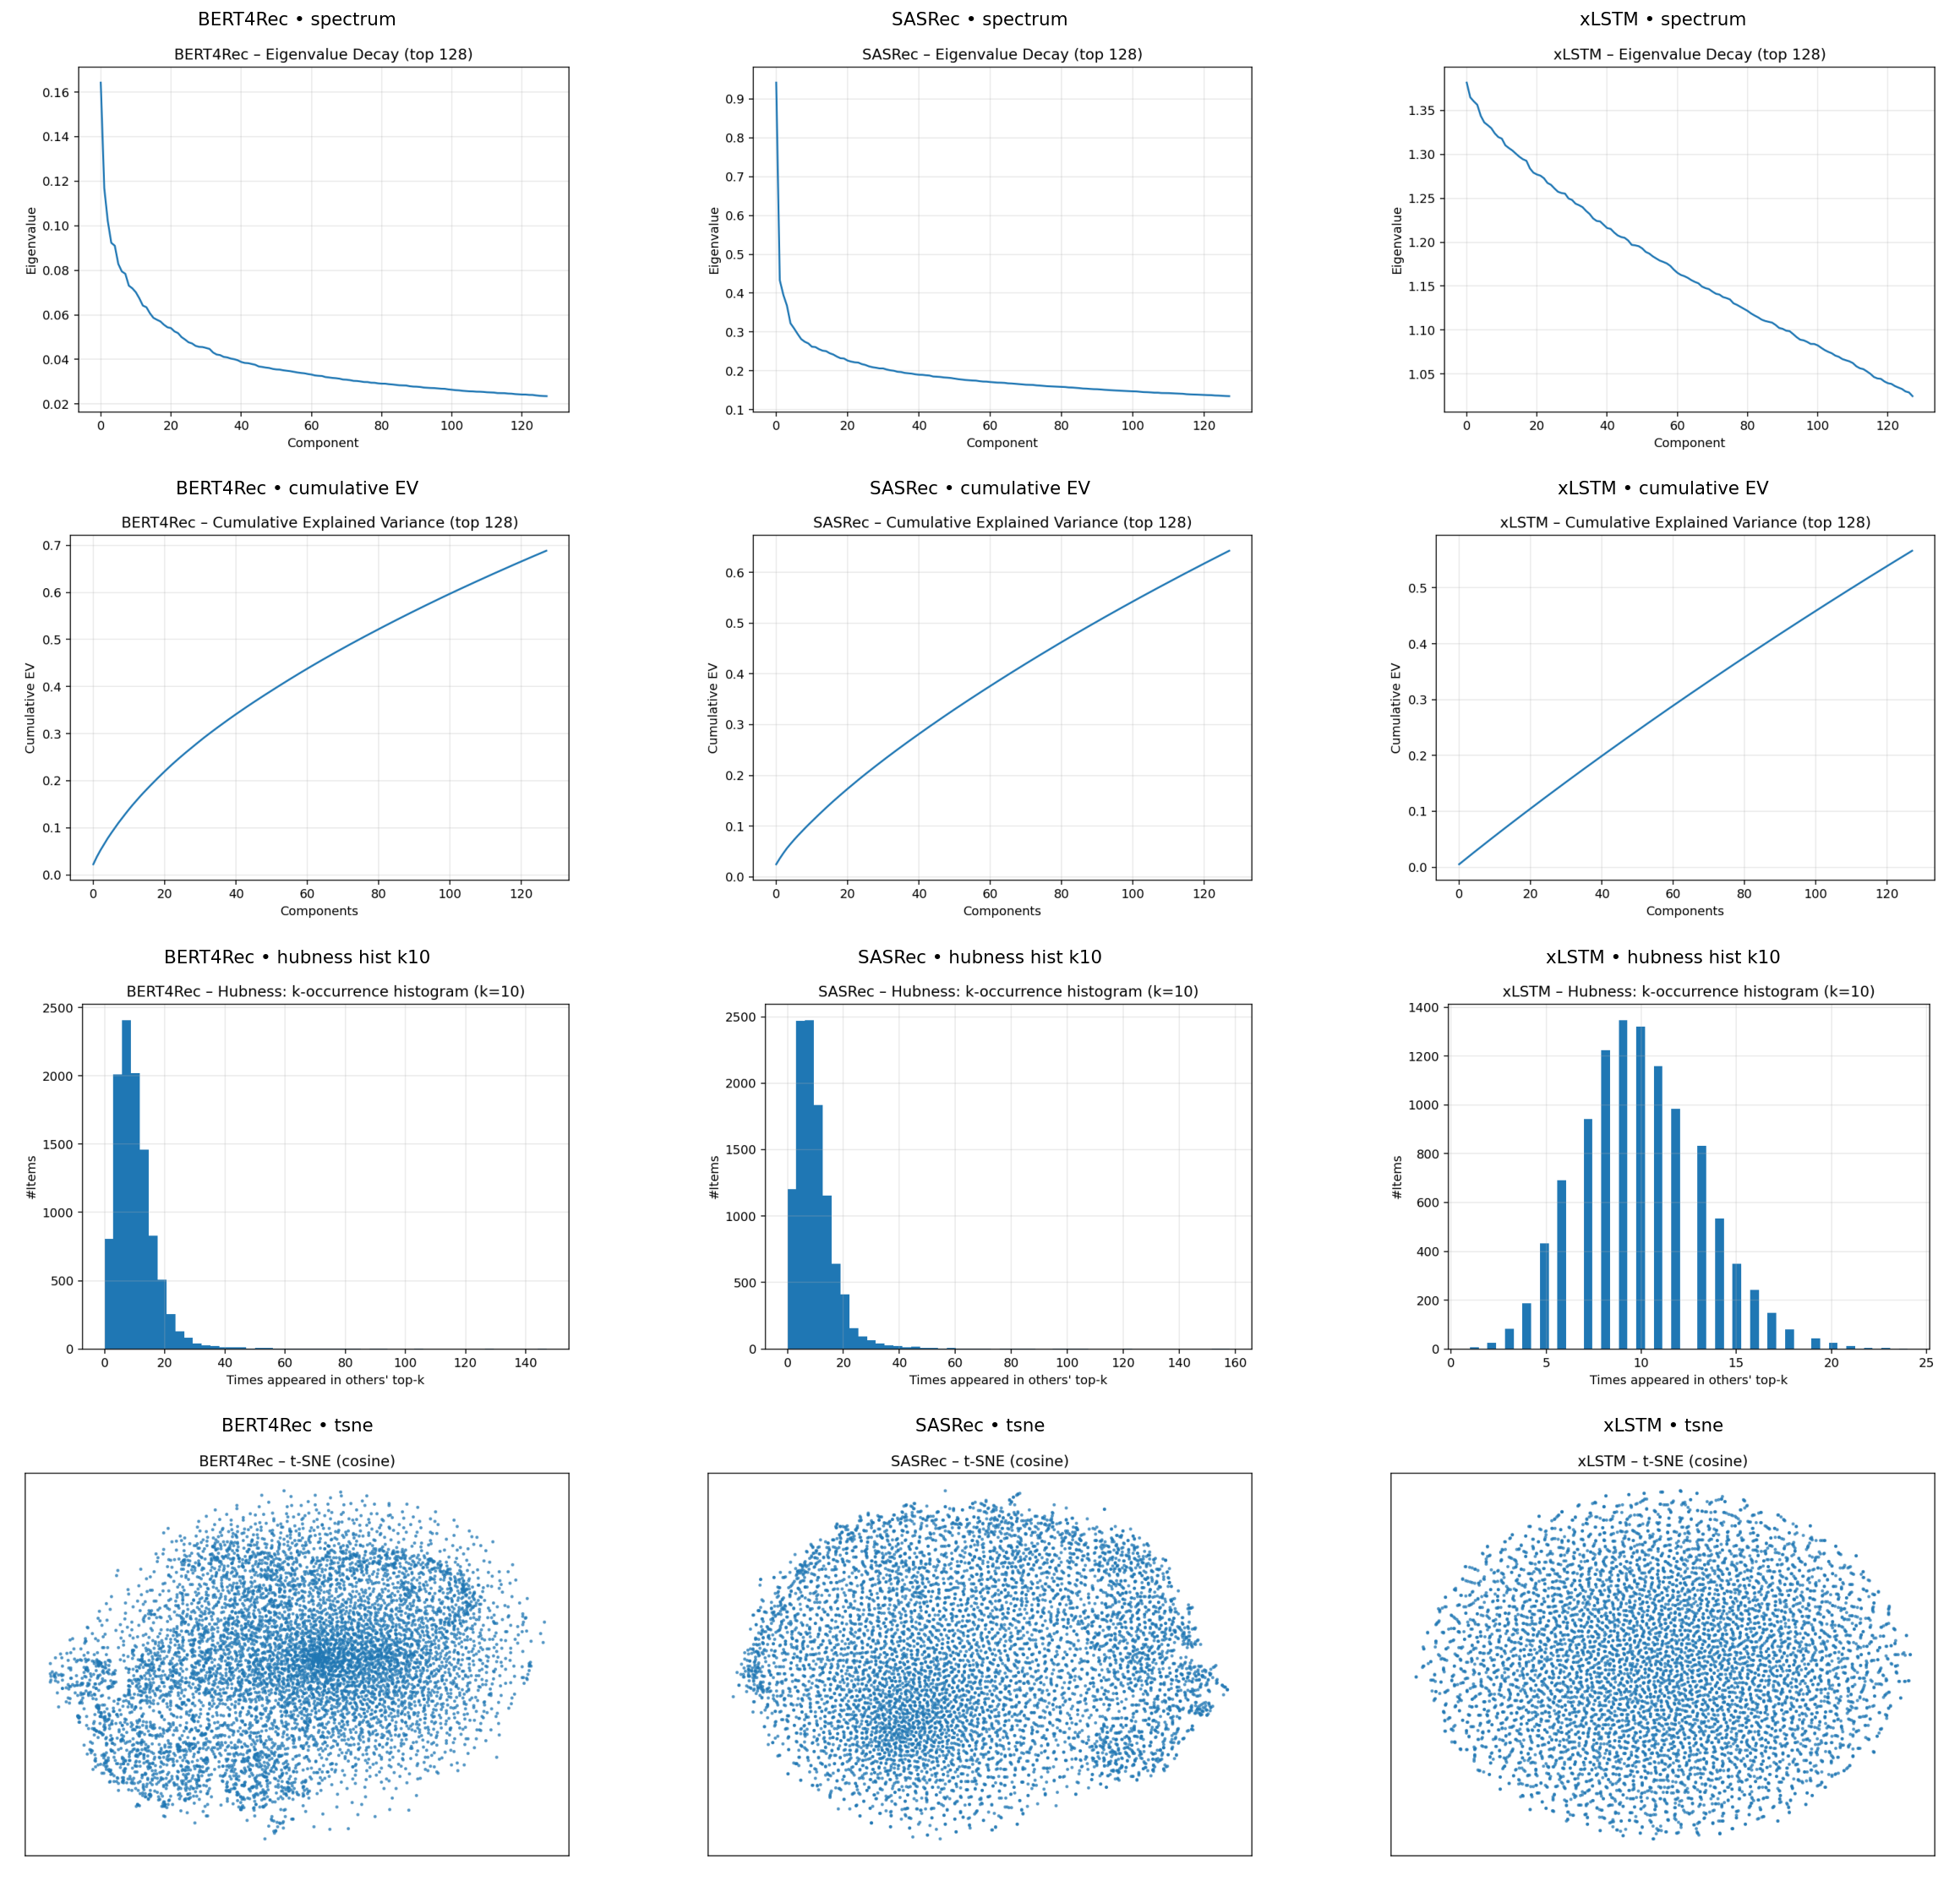

In [ ]:
# Display figures in a 3-column grid:
# Column 1 = BERT4Rec, Column 2 = SASRec, Column 3 = xLSTM
import os
import matplotlib.pyplot as plt
from PIL import Image

IMG_DIR = "/content/embedding_analysis"

# Expected figure types (each becomes a row)
figure_types = [
    "spectrum.png",            # Eigenvalue decay
    "cumulative_EV.png",       # Cumulative explained variance
    "hubness_hist_k10.png",    # Hubness histogram (k=10)
    "tsne.png",                # t-SNE 2D map
]

models = ["BERT4Rec", "SASRec", "xLSTM"]  # fixed column order

# Build a lookup: fig_paths[row][col] -> image path (or None if missing)
fig_paths = []
for ftype in figure_types:
    row_paths = []
    for m in models:
        fname = f"{m}_{ftype}"
        path = os.path.join(IMG_DIR, fname)
        row_paths.append(path if os.path.exists(path) else None)
    fig_paths.append(row_paths)

rows, cols = len(figure_types), len(models)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))

# If rows or cols == 1, coerce to 2D indexing
if rows == 1:
    axes = [axes]
if cols == 1:
    axes = [[ax] for ax in axes]

# Render each cell
for r in range(rows):
    for c in range(cols):
        ax = axes[r][c]
        path = fig_paths[r][c]
        title = f"{models[c]} • {figure_types[r].replace('_', ' ').replace('.png','')}"
        if path and os.path.exists(path):
            img = Image.open(path)
            ax.imshow(img)
            ax.set_title(title, fontsize=11)
            ax.axis("off")
        else:
            ax.text(0.5, 0.5, f"Missing:\n{title}", ha="center", va="center", fontsize=11)
            ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# ================================================
# Model Introspection: peek "all the data" inside
# BERT4Rec / SASRec / xLSTM checkpoints (.pt)
# - No model classes needed; loads raw state_dict
# - Prints clean summaries
# - Saves detailed CSV + JSON per model
# ================================================
import os, json, math, csv, re, gc
from collections import defaultdict
import torch

# ---- Configure your file paths here ----
PT_FILES = {
    "BERT4Rec": "best_model_10M_BERT4Rec_SL_100_Emb_256.pt",
    "SASRec"  : "best_model_10M_SAS4Rec_SL_128_Emb_256_seed_2023.pt",
    "xLSTM"   : "best_model_10M_xLSTM_SL_100_Emb_256.pt",  # ok if missing
}

OUT_DIR = "/content/model_introspection"
os.makedirs(OUT_DIR, exist_ok=True)

def load_raw_state_dict(path, device="cpu"):
    """Load a checkpoint and return the raw tensor dict (state_dict)."""
    sd = torch.load(path, map_location=device)
    if isinstance(sd, dict) and "state_dict" in sd and isinstance(sd["state_dict"], dict):
        return sd["state_dict"]
    if isinstance(sd, dict):
        # Some trainers nest as {"model": {...}} or similar; try to unwrap one level
        if "model" in sd and isinstance(sd["model"], dict):
            return sd["model"]
    return sd  # assume it's already a flat name->tensor mapping

def tensor_stats(t):
    """Return safe stats for a tensor (CPU, no-grad)."""
    try:
        tt = t.detach().cpu()
    except Exception:
        tt = torch.as_tensor(t).detach().cpu()
    numel = tt.numel()
    # To avoid huge compute on massive tensors, sample if > 10M elements
    if numel > 10_000_000:
        idx = torch.randint(0, numel, (2_000_000,))
        flat = tt.view(-1)[idx]
    else:
        flat = tt.view(-1)
    # basic stats
    minv = float(flat.min().item()) if flat.numel() else float("nan")
    maxv = float(flat.max().item()) if flat.numel() else float("nan")
    mean = float(flat.mean().item()) if flat.numel() else float("nan")
    std  = float(flat.std(unbiased=False).item()) if flat.numel() else float("nan")
    # zeros %
    zeros = float((flat == 0).sum().item()) / max(1, flat.numel())
    return dict(min=minv, max=maxv, mean=mean, std=std, zeros_pct=zeros)

def human_bytes(nbytes):
    units = ["B","KB","MB","GB","TB"]
    i = 0
    x = float(nbytes)
    while x >= 1024 and i < len(units)-1:
        x /= 1024.0; i += 1
    return f"{x:.2f} {units[i]}"

def dtype_nbytes(dtype: torch.dtype) -> int:
    return {
        torch.float64: 8, torch.double: 8,
        torch.float32: 4, torch.float: 4,
        torch.float16: 2, torch.half: 2,
        torch.bfloat16: 2,
        torch.int64: 8, torch.long: 8,
        torch.int32: 4, torch.int: 4,
        torch.int16: 2, torch.short: 2,
        torch.int8: 1, torch.uint8: 1,
        torch.bool: 1,
    }.get(dtype, 4)

def looks_like_embedding(name):
    name_l = name.lower()
    return any(s in name_l for s in [
        "embedding", "embeddings", "word_embeddings", "item_embedding", "token_embedding"
    ])

all_models_summary = {}

for model_name, path in PT_FILES.items():
    if not os.path.exists(path):
        print(f"⚠️ {model_name}: file not found -> {path} (skipping)")
        continue

    print(f"\n==================== {model_name} ====================")
    print(f"Loading: {path}")
    sd = load_raw_state_dict(path, device="cpu")
    if not isinstance(sd, dict):
        raise ValueError(f"{model_name}: Unexpected checkpoint format (not a dict).")

    rows = []
    total_params = 0
    total_bytes  = 0
    emb_candidates = []

    # iterate parameters
    for k, v in sd.items():
        if not torch.is_tensor(v):
            # Some checkpoints store non-tensor objects (ignore)
            continue
        shape = tuple(v.shape)
        numel = v.numel()
        dt    = v.dtype
        nbytes = numel * dtype_nbytes(dt)
        total_params += numel
        total_bytes  += nbytes

        stats = tensor_stats(v)  # min/max/mean/std/zeros%
        row = {
            "name": k,
            "shape": str(shape),
            "ndim": len(shape),
            "numel": int(numel),
            "dtype": str(dt).replace("torch.", ""),
            "size_bytes": int(nbytes),
            "size_human": human_bytes(nbytes),
            "min": stats["min"],
            "max": stats["max"],
            "mean": stats["mean"],
            "std": stats["std"],
            "zeros_pct": stats["zeros_pct"],
            "is_embedding_like": looks_like_embedding(k),
        }
        rows.append(row)
        if row["is_embedding_like"]:
            emb_candidates.append((k, shape, row["size_human"]))

    # sort by size (descending) for on-screen summary
    rows_sorted = sorted(rows, key=lambda r: r["numel"], reverse=True)
    # try to infer vocab size from a likely embedding
    vocab_guess = None
    emb_dim_guess = None
    for r in rows_sorted:
        if r["is_embedding_like"]:
            try:
                shp = eval(r["shape"])
                if len(shp) == 2:
                    vocab_guess = shp[0]
                    emb_dim_guess = shp[1]
                    break
            except Exception:
                pass

    # Print concise summary
    print(f"Parameters: {total_params:,}  |  Approx size: {human_bytes(total_bytes)}")
    if vocab_guess and emb_dim_guess:
        print(f"Embedding guess → vocab_size≈{vocab_guess}, embedding_dim≈{emb_dim_guess}")
    if emb_candidates:
        print("Embedding-like tensors (top):")
        for i, (k, shp, sz) in enumerate(emb_candidates[:5], 1):
            print(f"  {i:>2}. {k:50s}  shape={shp}  ~{sz}")

    # Top-10 largest tensors
    print("\nTop-10 largest tensors by parameter count:")
    for i, r in enumerate(rows_sorted[:10], 1):
        print(f"{i:>2}. {r['name']:50s}  shape={r['shape']:>18s}  {r['dtype']:>8s}  params={r['numel']:,}  ~{r['size_human']}")

    # Save CSV
    csv_path = os.path.join(OUT_DIR, f"{model_name}_state_dict_summary.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["name","shape","ndim","numel","dtype","size_bytes","size_human","min","max","mean","std","zeros_pct","is_embedding_like"])
        for r in rows_sorted:
            writer.writerow([r["name"], r["shape"], r["ndim"], r["numel"], r["dtype"], r["size_bytes"], r["size_human"],
                             r["min"], r["max"], r["mean"], r["std"], r["zeros_pct"], r["is_embedding_like"]])

    # Save JSON (full)
    json_path = os.path.join(OUT_DIR, f"{model_name}_state_dict_summary.json")
    with open(json_path, "w") as f:
        json.dump({
            "model": model_name,
            "file": path,
            "total_params": int(total_params),
            "total_size_bytes": int(total_bytes),
            "total_size_human": human_bytes(total_bytes),
            "embedding_guess": {"vocab_size": vocab_guess, "embedding_dim": emb_dim_guess},
            "tensors": rows_sorted
        }, f, indent=2)

    all_models_summary[model_name] = {
        "file": path,
        "total_params": int(total_params),
        "total_size_human": human_bytes(total_bytes),
        "embedding_guess": {"vocab_size": vocab_guess, "embedding_dim": emb_dim_guess},
        "csv": csv_path,
        "json": json_path,
    }

# Master index
master_path = os.path.join(OUT_DIR, "MASTER_SUMMARY.json")
with open(master_path, "w") as f:
    json.dump(all_models_summary, f, indent=2)

print("\n==================== Done ====================")
print(f"Saved detailed summaries to: {OUT_DIR}")
print("MASTER_SUMMARY.json created with quick links to per-model CSV/JSON.")



==================== BERT4Rec ====================
Loading: best_model_10M_BERT4Rec_SL_100_Emb_256.pt
Parameters: 8,729,782  |  Approx size: 33.30 MB
Embedding guess → vocab_size≈10678, embedding_dim≈256
Embedding-like tensors (top):
   1. bert.embeddings.word_embeddings.weight              shape=(10678, 256)  ~10.43 MB
   2. bert.embeddings.position_embeddings.weight          shape=(102, 256)  ~102.00 KB
   3. bert.embeddings.token_type_embeddings.weight        shape=(2, 256)  ~2.00 KB
   4. bert.embeddings.LayerNorm.weight                    shape=(256,)  ~1.00 KB
   5. bert.embeddings.LayerNorm.bias                      shape=(256,)  ~1.00 KB

Top-10 largest tensors by parameter count:
 1. bert.embeddings.word_embeddings.weight              shape=      (10678, 256)   float32  params=2,733,568  ~10.43 MB
 2. output_layer.weight                                 shape=      (10678, 256)   float32  params=2,733,568  ~10.43 MB
 3. bert.encoder.layer.0.intermediate.dense.weight      shape

In [ ]:
import torch
data = torch.load("best_model_10M_BERT4Rec_SL_100_Emb_256.pt", map_location="cpu")
type(data)


collections.OrderedDict

In [ ]:
import torch

sd = torch.load("best_model_10M_BERT4Rec_SL_100_Emb_256.pt", map_location="cpu")
print(type(sd))
print("Total keys:", len(sd))
for i, (k, v) in enumerate(sd.items()):
    print(f"{i:03d}: {k:50s} {tuple(v.shape)} {v.dtype}")
    if i > 80: break  # show first 20


<class 'collections.OrderedDict'>
Total keys: 73
000: bert.embeddings.word_embeddings.weight             (10678, 256) torch.float32
001: bert.embeddings.position_embeddings.weight         (102, 256) torch.float32
002: bert.embeddings.token_type_embeddings.weight       (2, 256) torch.float32
003: bert.embeddings.LayerNorm.weight                   (256,) torch.float32
004: bert.embeddings.LayerNorm.bias                     (256,) torch.float32
005: bert.encoder.layer.0.attention.self.query.weight   (256, 256) torch.float32
006: bert.encoder.layer.0.attention.self.query.bias     (256,) torch.float32
007: bert.encoder.layer.0.attention.self.key.weight     (256, 256) torch.float32
008: bert.encoder.layer.0.attention.self.key.bias       (256,) torch.float32
009: bert.encoder.layer.0.attention.self.value.weight   (256, 256) torch.float32
010: bert.encoder.layer.0.attention.self.value.bias     (256,) torch.float32
011: bert.encoder.layer.0.attention.output.dense.weight (256, 256) torch.float32

In [ ]:
import torch
sd = torch.load("best_model_10M_SAS4Rec_SL_128_Emb_256_seed_2023.pt", map_location="cpu")
E = sd["item_embedding.weight"]  # [10678, 256]
print(E.shape, E.dtype)
print("First 2 rows:\n", E[:2])
print("Mean/std:", E.mean().item(), E.std().item())


torch.Size([10678, 256]) torch.float32
First 2 rows:
 tensor([[ 4.8683e-03, -3.6243e-02, -9.6350e-04, -5.4655e-03, -1.5166e-02,
          2.7941e-02,  2.5654e-02,  3.9152e-02,  6.5415e-03, -3.2066e-03,
         -8.0724e-03, -1.1158e-02,  6.4706e-02, -2.7313e-02, -4.2456e-02,
         -8.3490e-03, -4.2322e-03, -2.5044e-02, -1.9668e-02, -3.3877e-02,
          6.3485e-03,  2.8368e-03, -2.8132e-02, -4.5819e-02,  2.1315e-02,
         -2.8296e-02, -1.7670e-02, -1.0538e-02,  5.3288e-03,  4.4695e-02,
         -2.6942e-02,  3.0353e-03,  1.7462e-02, -2.1932e-02,  6.2545e-03,
          2.8588e-02, -1.4245e-02,  1.3119e-02,  2.2746e-02, -1.0917e-02,
          2.8912e-02, -6.3681e-03, -8.2891e-03,  1.1344e-03,  1.4321e-02,
         -8.3202e-03, -3.4500e-02, -2.7030e-02, -4.2646e-03, -2.8879e-02,
          3.3380e-03,  2.2594e-02, -7.9163e-04, -6.9470e-03, -3.7214e-02,
         -2.5981e-02, -2.1731e-02,  1.0772e-02,  6.8849e-04, -1.9132e-02,
         -1.5471e-02, -1.1770e-02,  2.5482e-02,  1.4622e-0

In [ ]:
import torch

# Load xLSTM checkpoint
path = "best_model_10M_xLSTM_SL_100_Emb_256.pt"

# Load state dict
sd = torch.load(path, map_location="cpu")

# Extract embedding matrix (vocab_size x embedding_dim)
E = sd["embedding.weight"]   # for xLSTM

print("✅ Loaded xLSTM embedding matrix")
print("Shape :", E.shape)
print("Dtype :", E.dtype)
print("First 2 rows:\n", E[:2])
print("Mean  :", E.mean().item())
print("Std   :", E.std().item())


✅ Loaded xLSTM embedding matrix
Shape : torch.Size([10678, 256])
Dtype : torch.float32
First 2 rows:
 tensor([[ 1.2606e+00, -1.8944e+00,  1.3030e+00,  1.9169e-01, -2.0666e-01,
         -1.1345e-01,  1.3523e+00,  6.7165e-01, -7.8567e-01,  1.2255e+00,
         -3.4379e-01, -2.4721e-01, -1.8723e+00,  3.2486e-01, -5.3398e-01,
         -6.5671e-01, -8.0084e-02,  6.1088e-01, -6.1788e-01,  3.5379e-01,
         -2.6377e-01, -4.9646e-01, -9.7859e-02, -5.7313e-02, -3.6298e-01,
         -1.5183e+00,  4.2267e-01,  8.4007e-01, -8.0470e-01, -3.6895e-01,
         -1.1020e-01, -3.2081e-01, -2.3382e+00, -5.2732e-01,  3.6396e-01,
         -1.8826e-01, -1.2096e-01,  3.4431e+00, -1.1102e+00,  1.0413e+00,
         -1.6895e-01, -1.9129e+00, -1.4860e-01,  9.5695e-01, -4.2954e-01,
          3.4940e-01,  1.3393e+00, -8.7957e-01, -1.3316e+00,  8.5673e-01,
          1.8311e+00, -4.9652e-01, -4.0488e-01,  8.1004e-02, -4.8645e-01,
          1.0567e-01,  1.7359e-01, -1.0225e+00, -8.4156e-02,  5.3381e-01,
         -

In [ ]:
# ==========================================================
# NEW USER INFERENCE WITH xLSTM — STEP BY STEP (PRINTS!)
# Uses your trained .pt file:
#   - Preferred: run with real xLSTM model if module importable
#   - Fallback: runs with embedding-only (MF-style) to illustrate flow
# Everything prints in detail at each step.
# ==========================================================

import os, re, math, random, json
import numpy as np
import torch
import torch.nn as nn

# -----------------------------
# 0) CONFIG: point to your .pt
# -----------------------------
XLSTM_PT = "best_model_10M_xLSTM_SL_100_Emb_256.pt"  # update if different
random.seed(0); np.random.seed(0); torch.manual_seed(0)

assert os.path.exists(XLSTM_PT), f"Checkpoint not found: {XLSTM_PT}"

# -----------------------------
# 1) Load state_dict (weights)
# -----------------------------
print("Step 1: Loading xLSTM checkpoint (state_dict)")
sd = torch.load(XLSTM_PT, map_location="cpu")
if isinstance(sd, dict) and "state_dict" in sd and isinstance(sd["state_dict"], dict):
    sd = sd["state_dict"]
print(f" - Loaded object type: {type(sd)}")
print(f" - Keys in state_dict: {len(sd)} parameters")

# -----------------------------
# 2) Identify core tensors
# -----------------------------
def find_key_endswith(keys, suffixes):
    for k in keys:
        for s in suffixes:
            if k.endswith(s):
                return k
    return None

keys = list(sd.keys())
emb_key = find_key_endswith(keys, ["embedding.weight", "embeddings.weight", "item_embedding.weight"])
assert emb_key is not None, "Could not find embedding weight in state_dict."
E = sd[emb_key]  # [vocab_size, emb_dim]
vocab_size, emb_dim = E.shape
num_items = vocab_size - 1  # row 0 is padding

print("Step 2: Found item embedding matrix")
print(f" - Key name             : {emb_key}")
print(f" - Shape [V, D]         : {tuple(E.shape)}  (V=vocab_size, D=embedding_dim)")
print(f" - vocab_size (incl pad): {vocab_size}  -> num_items: {num_items}")
print(f" - dtype                : {E.dtype}")
print(f" - Example, first row   : padding row (should be zeros) -> {E[0, :6].tolist()}")

# Try to parse max_len (sequence length) from filename as in your training logs, e.g. SL_100
def parse_from_filename(path):
    m_len = re.search(r"SL[_:](\d+)", path)
    m_emb = re.search(r"Emb[_:](\d+)", path)
    max_len = int(m_len.group(1)) if m_len else 100
    emb = int(m_emb.group(1)) if m_emb else emb_dim
    return max_len, emb

max_len_from_name, emb_from_name = parse_from_filename(XLSTM_PT)
print("Step 2b: Parsed model config hints from filename")
print(f" - max_len (target input length): {max_len_from_name}")
print(f" - embedding_dim (from name)    : {emb_from_name}")

# -----------------------------
# 3) Build/Load the xLSTM model if possible
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Step 3: Device selection -> {DEVICE}")

xLSTM_AVAILABLE = False
try:
    # If you have the xlstm package available in your environment, this will work.
    # If not, we continue with a fallback path that still demonstrates the flow.
    from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge
    xLSTM_AVAILABLE = True
    print(" - xLSTM module import: SUCCESS")
except Exception as e:
    print(f" - xLSTM module import: FAILED ({repr(e)}). Will use fallback explanation mode.")

model = None
if xLSTM_AVAILABLE:
    print("Step 3b: Constructing xLSTMLarge and loading weights (strict=False for safety)")
    # We must know vocab_size and emb_dim; we have them from E.shape
    xl_cfg = xLSTMLargeConfig(
        embedding_dim=emb_dim,
        num_heads=8,
        num_blocks=4,
        vocab_size=vocab_size,
        return_last_states=True,  # as in your training
        mode="train",             # forward returns (logits, states) or similar
        chunkwise_kernel="chunkwise--triton_xl_chunk",
        sequence_kernel="native_sequence__triton",
        step_kernel="triton"
    )
    model = xLSTMLarge(xl_cfg)
    # Load the checkpoint
    missing = model.load_state_dict(sd, strict=False)  # tolerate minor key name differences
    print(f" - Missing keys   : {len(missing.missing_keys)} (ok if non-critical)")
    print(f" - Unexpected keys: {len(missing.unexpected_keys)}")
    model.eval().to(DEVICE)
else:
    print("Step 3b: Skipping real model construction (fallback path).")

# -----------------------------
# 4) Define a NEW USER sequence (internal item IDs)
#    NOTE: These are *internal* indices 1..num_items
#    For a real app, you'd map raw MovieLens movieId -> internal index.
# -----------------------------
print("Step 4: Defining a NEW USER sequence (internal item IDs)")
# For demonstration, pick a short realistic history (5–10 items).
# You can replace this with your own internal item IDs (1..num_items).
NEW_USER_INTERNAL_IDS = [101, 550, 2123, 875, 4321, 9001, 1234]
# Clip any accidental out-of-range ids
NEW_USER_INTERNAL_IDS = [min(max(1, x), num_items) for x in NEW_USER_INTERNAL_IDS]
print(f" - Raw sequence (right = most recent): {NEW_USER_INTERNAL_IDS}")

# -----------------------------
# 5) Pad/trim to model input length (left padding with 0)
# -----------------------------
def pad_left(seq, max_len):
    s = seq[-max_len:]  # keep most recent max_len
    return [0]*(max_len - len(s)) + s

INPUT_IDS = pad_left(NEW_USER_INTERNAL_IDS, max_len_from_name)
x = torch.tensor([INPUT_IDS], dtype=torch.long, device=DEVICE)  # [B=1, T=max_len]
print("Step 5: Prepared model input")
print(f" - Input length (T)             : {len(INPUT_IDS)} (padded/truncated to max_len)")
print(f" - First 10 time steps (ids)    : {INPUT_IDS[:10]}")
print(f" - Last 10 time steps (ids)     : {INPUT_IDS[-10:]}")
print(f" - x tensor shape / dtype / dev : {tuple(x.shape)} / {x.dtype} / {x.device}")

# -----------------------------
# 6) Look up embeddings for this sequence (for understanding)
# -----------------------------
with torch.no_grad():
    # CPU for printing small slices is fine
    seq_ids_cpu = torch.tensor([INPUT_IDS], dtype=torch.long)
    E_cpu = E.detach().cpu()
    embedded_seq = E_cpu[seq_ids_cpu]  # [1, T, D]
print("Step 6: Embedding lookup (what the model sees)")
print(f" - Embedded sequence shape [1,T,D]: {tuple(embedded_seq.shape)}")
print(f" - Example (last non-pad token id): {INPUT_IDS[-1]} -> first 6 dims: {embedded_seq[0, -1, :6].tolist()}")

# -----------------------------
# 7) Forward pass
#    A) Preferred: real xLSTM model forward (if available)
#    B) Fallback: simple decayed pooling over embeddings (MF-style)
# -----------------------------
TOPK = 10

if model is not None:
    print("Step 7A: REAL xLSTM forward pass")
    with torch.no_grad():
        out = model(x)  # model may return logits or (logits, states)
        if isinstance(out, tuple):
            logits = out[0]
            last_states = out[1] if len(out) > 1 else None
            print(f" - Model returned a tuple: logits shape {tuple(logits.shape)}; also states present: {last_states is not None}")
        else:
            logits = out
            print(f" - Model returned logits directly: shape {tuple(logits.shape)}")

        if logits.dim() == 3:
            # [B, T, V] -> take last step
            logits = logits[:, -1, :]
            print(" - Took last time-step logits")

        # Softmax to probabilities
        probs = torch.softmax(logits, dim=-1)  # [B, V]
        top_vals, top_idx = torch.topk(probs, k=TOPK, dim=-1)

        top_idx_cpu = top_idx[0].detach().cpu().tolist()
        top_vals_cpu = top_vals[0].detach().cpu().tolist()

    print("Step 7A result: Top-10 recommended internal item IDs (with probabilities)")
    for rank, (iid, p) in enumerate(zip(top_idx_cpu, top_vals_cpu), start=1):
        tag = "(PAD)" if iid == 0 else ""
        print(f"   {rank:2d}. item_id={iid:5d}  prob={p:.6f} {tag}")

else:
    print("Step 7B: FALLBACK — explain with embedding-only scoring")
    print(" - We’ll simulate xLSTM’s user state as a RECENCY-WEIGHTED average of item embeddings.")
    print(" - This is NOT the exact model, but it illustrates the same flow conceptually.")
    with torch.no_grad():
        T = len(INPUT_IDS)
        ids = np.array(INPUT_IDS, dtype=np.int64)
        # Build exponential recency weights (newer = heavier)
        gamma = 0.9  # decay factor per step from the end
        print(f" - Recency decay gamma: {gamma}")
        # mask out pads
        valid_mask = (ids > 0).astype(np.float32)
        positions = np.arange(T)
        # more weight to later (right-most) positions
        recency = gamma ** (T - 1 - positions)
        recency *= valid_mask
        if recency.sum() == 0:
            recency = np.ones_like(recency)
        recency = recency / recency.sum()
        print(f" - Recency weights (first 10): {recency[:10].round(4).tolist()}")
        print(f" - Recency weights (last  10): {recency[-10:].round(4).tolist()}")

        # Build user vector: weighted sum of embeddings
        E_np = E.detach().cpu().numpy()
        seq_vecs = E_np[ids]  # [T, D]
        user_vec = (recency[:, None] * seq_vecs).sum(axis=0)  # [D]
        print(f" - User vector built from embeddings: shape {user_vec.shape}, first 6 dims: {user_vec[:6].round(6).tolist()}")

        # Score all items by cosine similarity (or dot product) to user_vec
        # We’ll use cosine similarity for interpretability.
        eps = 1e-9
        E_norm = E_np / (np.linalg.norm(E_np, axis=1, keepdims=True) + eps)
        u_norm = user_vec / (np.linalg.norm(user_vec) + eps)
        scores = E_norm @ u_norm  # [V]
        # Ignore padding item 0
        scores[0] = -1.0
        top_idx_cpu = scores.argsort()[::-1][:TOPK]
        top_vals_cpu = scores[top_idx_cpu]

    print("Step 7B result: Top-10 recommended internal item IDs (cosine similarity)")
    for rank, (iid, s) in enumerate(zip(top_idx_cpu, top_vals_cpu), start=1):
        tag = "(PAD)" if int(iid) == 0 else ""
        print(f"   {rank:2d}. item_id={int(iid):5d}  cosine={float(s):.6f} {tag}")

# -----------------------------
# 8) Concept recap (printed)
# -----------------------------
print("\nStep 8: What you just saw — concept recap")
print(" - The embedding matrix E[V,D] stores one learned vector per movie (row).")
print(" - We formed an input sequence by LEFT-PADDING zeros to max_len and keeping the most recent items.")
print(" - REAL PATH (if xlstm module present):")
print("     The model encodes the sequence -> produces logits over all movies -> softmax -> top-K items.")
print(" - FALLBACK PATH (if xlstm not present):")
print("     We built a user vector by a recency-weighted average of the movie embeddings, then scored")
print("     all movies by cosine similarity to that user vector. This mirrors the *idea* of the real model's")
print("     final step (compare user state to each item), but without its recurrent dynamics.")

# -----------------------------
# 9) OPTIONAL: Map internal IDs -> titles (if you have a mapping)
#    You can insert your item2title dict here to print titles instead of internal IDs.
# -----------------------------
print("\nOptional next step:")
print(" - If you have a dict 'movie_titles: internal_item_id -> title',")
print("   you can replace the printouts to show human-readable titles.")
print(" - Internal IDs here are in [1..num_items] and match rows of E.")


Step 1: Loading xLSTM checkpoint (state_dict)
 - Loaded object type: <class 'collections.OrderedDict'>
 - Keys in state_dict: 63 parameters
Step 2: Found item embedding matrix
 - Key name             : embedding.weight
 - Shape [V, D]         : (10678, 256)  (V=vocab_size, D=embedding_dim)
 - vocab_size (incl pad): 10678  -> num_items: 10677
 - dtype                : torch.float32
 - Example, first row   : padding row (should be zeros) -> [1.2606167793273926, -1.8943921327590942, 1.3030204772949219, 0.19169370830059052, -0.2066594958305359, -0.11345422267913818]
Step 2b: Parsed model config hints from filename
 - max_len (target input length): 100
 - embedding_dim (from name)    : 256
Step 3: Device selection -> cpu
 - xLSTM module import: FAILED (ModuleNotFoundError("No module named 'xlstm'")). Will use fallback explanation mode.
Step 3b: Skipping real model construction (fallback path).
Step 4: Defining a NEW USER sequence (internal item IDs)
 - Raw sequence (right = most recent): [1

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from scipy.stats import gaussian_kde

# # --- Load embeddings ---
# bert_E = torch.nn.functional.normalize(torch.load("best_model_10M_BERT4Rec_SL_100_Emb_256.pt", map_location="cpu")["bert.embeddings.word_embeddings.weight"].float(), dim=1)
# sas_E  = torch.nn.functional.normalize(torch.load("best_model_10M_SAS4Rec_SL_128_Emb_256_seed_2023.pt", map_location="cpu")["item_embedding.weight"].float(), dim=1)
# xlstm_E = torch.nn.functional.normalize(torch.load("best_model_10M_xLSTM_SL_100_Emb_256.pt", map_location="cpu")["embedding.weight"].float(), dim=1)

# # --- Project to 2D via PCA ---
# def project_2d(E):
#     pca = PCA(n_components=2)
#     return pca.fit_transform(E.numpy())

# bert_2d, sas_2d, xlstm_2d = project_2d(bert_E), project_2d(sas_E), project_2d(xlstm_E)

# # --- 3D density surface ---
# def plot_3d_density(ax, data, title, color='viridis'):
#     x, y = data[:,0], data[:,1]
#     k = gaussian_kde(np.vstack([x, y]))
#     xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
#     zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#     zi = zi.reshape(xi.shape)
#     ax.plot_surface(xi, yi, zi, cmap=color, rstride=2, cstride=2, linewidth=0)
#     ax.set_title(title)
#     ax.set_xlabel('PCA-1')
#     ax.set_ylabel('PCA-2')

# fig = plt.figure(figsize=(12,4))
# ax1 = fig.add_subplot(131, projection='3d')
# ax2 = fig.add_subplot(132, projection='3d')
# ax3 = fig.add_subplot(133, projection='3d')

# plot_3d_density(ax1, bert_2d, "BERT4Rec")
# plot_3d_density(ax2, sas_2d, "SASRec")
# plot_3d_density(ax3, xlstm_2d, "xLSTM")

# plt.tight_layout()
# plt.show()


In [3]:
# Check the latest Python Version, not needed everytime but to ensure if any updates
import json
import urllib.request

def get_latest_version(package_name):
    url = f"https://pypi.org/pypi/{package_name}/json"
    with urllib.request.urlopen(url) as r:
        data = json.load(r)
    return data["info"]["version"]

packages = ["mlstm_kernels", "xlstm", "torch", "torchvision", "torchaudio"]
for pkg in packages:
    print(f"{pkg}: {get_latest_version(pkg)}")

mlstm_kernels: 2.0.2
xlstm: 2.0.5
torch: 2.9.1
torchvision: 0.24.1
torchaudio: 2.9.1


In [4]:
import random, numpy as np, torch, subprocess


# List of packages with exact versions
pkgs = [
    "mlstm_kernels==2.0.0",
    "xlstm==2.0.4",
    "torch==2.7.1",
    "torchvision==0.22.1",
    "torchaudio==2.7.1"
]

# Install with CUDA 12.1 index URL and no output
subprocess.run([
    "pip", "install", "--upgrade", *pkgs,
    "--index-url", "https://download.pytorch.org/whl/cu121"
], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

print("Installed: mlstm_kernels==2.0.0, xlstm==2.0.4, torch==2.7.1, torchvision==0.22.1, torchaudio==2.7.1")



Installed: mlstm_kernels==2.0.0, xlstm==2.0.4, torch==2.7.1, torchvision==0.22.1, torchaudio==2.7.1


In [6]:
!pip install -q xlstm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.6 MB/s eta 0:00:00


In [7]:
!mkdir -p /usr/local/lib
!ln -sf /usr/lib64-nvidia/libcuda.so /usr/local/lib/libcuda.so

In [8]:
!find /usr -name "build.py" | grep triton

/usr/local/lib/python3.12/dist-packages/triton/runtime/build.py


In [10]:
path = "/usr/local/lib/python3.12/dist-packages/triton/runtime/build.py"

with open(path, "r") as f:
    lines = f.readlines()

patched_lines = []
for line in lines:
    if "dirs = [" in line:
        patched_lines.append('    dirs = ["/usr/lib64-nvidia", "/usr/local/lib"]  # patched\n')
    elif "assert any(os.path.exists(" in line:
        patched_lines.append('    # assertion disabled for libcuda.so\n')
    else:
        patched_lines.append(line)

with open(path, "w") as f:
    f.writelines(patched_lines)

print("GPU Check 1: Triton 3.1.0 patched for Colab CUDA.")


GPU Check 1: Triton 3.1.0 patched for Colab CUDA.


In [11]:
import os
os.environ["TRITON_DEBUG"] = "1"
os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/lib"
os.environ["LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/lib"
os.environ["PATH"] += ":/usr/local/lib"

import triton
import triton.language as tl
import torch

@triton.jit
def add_kernel(X_ptr, Y_ptr, Z_ptr, N: tl.constexpr):
    pid = tl.program_id(0)
    if pid >= N:
        return
    x = tl.load(X_ptr + pid)
    y = tl.load(Y_ptr + pid)
    tl.store(Z_ptr + pid, x + y)

# Test kernel
size = 1024
X = torch.rand(size, device='cuda')
Y = torch.rand(size, device='cuda')
Z = torch.empty(size, device='cuda')

add_kernel[(size,)](X, Y, Z, N=size)
print(" GPU Check 2: Triton 3.x kernel executed successfully!")
print(Z[:5])

 GPU Check 2: Triton 3.x kernel executed successfully!
tensor([0.9962, 0.9376, 1.1724, 1.6138, 1.0519], device='cuda:0')


Device: cpu
⚠️ xLSTM package not found, using LSTM proxy: No module named 'xlstm'
Loaded: BERT4Rec
Loaded: SASRec
Loaded: LSTM proxy
BERT4Rec     | bs= 32 L=  10  mean=47.82 ms  ±4.07   tok/s=6692
BERT4Rec     | bs= 32 L=  25  mean=128.85 ms  ±28.66   tok/s=6209
BERT4Rec     | bs= 32 L=  50  mean=229.97 ms  ±47.36   tok/s=6957
BERT4Rec     | bs= 32 L= 100  mean=740.28 ms  ±349.37   tok/s=4323
BERT4Rec     | bs= 32 L= 200  mean=1253.14 ms  ±360.24   tok/s=5107
BERT4Rec     | bs= 32 L= 400  mean=3110.31 ms  ±375.86   tok/s=4115
BERT4Rec     | bs= 64 L=  10  mean=88.73 ms  ±4.28   tok/s=7213
BERT4Rec     | bs= 64 L=  25  mean=230.99 ms  ±44.83   tok/s=6927
BERT4Rec     | bs= 64 L=  50  mean=453.72 ms  ±79.49   tok/s=7053
BERT4Rec     | bs= 64 L= 100  mean=980.10 ms  ±154.33   tok/s=6530
BERT4Rec     | bs= 64 L= 200  mean=2505.89 ms  ±371.85   tok/s=5108
BERT4Rec     | bs= 64 L= 400  mean=6453.97 ms  ±1148.20   tok/s=3967


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(


SASRec       | bs= 32 L=  10  mean=47.41 ms  ±3.52   tok/s=6749
SASRec       | bs= 32 L=  25  mean=124.72 ms  ±29.09   tok/s=6414
SASRec       | bs= 32 L=  50  mean=243.33 ms  ±45.07   tok/s=6575
SASRec       | bs= 32 L= 100  mean=542.58 ms  ±92.60   tok/s=5898
SASRec       | bs= 32 L= 200  mean=1553.53 ms  ±217.33   tok/s=4120
SASRec       | bs= 32 L= 400  mean=5175.19 ms  ±1241.04   tok/s=2473
SASRec       | bs= 64 L=  10  mean=89.94 ms  ±5.11   tok/s=7116
SASRec       | bs= 64 L=  25  mean=239.68 ms  ±45.26   tok/s=6676
SASRec       | bs= 64 L=  50  mean=492.93 ms  ±90.25   tok/s=6492
SASRec       | bs= 64 L= 100  mean=1119.71 ms  ±204.73   tok/s=5716
SASRec       | bs= 64 L= 200  mean=3675.58 ms  ±959.42   tok/s=3482
SASRec       | bs= 64 L= 400  mean=10396.25 ms  ±1397.03   tok/s=2462
LSTM proxy   | bs= 32 L=  10  mean=14.65 ms  ±1.46   tok/s=21847
LSTM proxy   | bs= 32 L=  25  mean=39.14 ms  ±5.68   tok/s=20437
LSTM proxy   | bs= 32 L=  50  mean=47.69 ms  ±3.90   tok/s=33547
LSTM

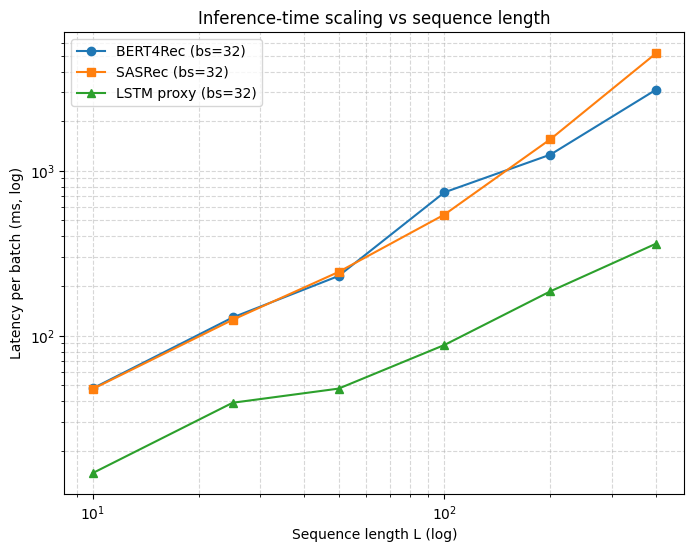


Estimated scaling exponent (alpha) from log–log fit (batch = 32):
  BERT4Rec      alpha ≈ 1.14  (1≈linear, 2≈quadratic)
  SASRec        alpha ≈ 1.25  (1≈linear, 2≈quadratic)
  LSTM proxy    alpha ≈ 0.84  (1≈linear, 2≈quadratic)


In [ ]:
import time, math, torch, numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# --------- constants from your checkpoints ---------
VOCAB = 10678        # items incl. padding id 0
EMB_DIM = 256
MAX_TEST_L = 512
BATCHES = [32, 64]
SEQ_LENS = [10, 25, 50, 100, 200, 400]
WARMUP = 10
REPEATS = 60

import torch.nn as nn

class TinyBERT4Rec(nn.Module):
    def __init__(self, vocab_size, d_model=EMB_DIM, nhead=8, nlayers=4, max_len=MAX_TEST_L):
        super().__init__()
        self.item_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_emb  = nn.Embedding(max_len, d_model)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
                                           batch_first=True)
        self.enc = nn.TransformerEncoder(layer, num_layers=nlayers)
        self.norm = nn.LayerNorm(d_model)
        self.out  = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        B,T = x.shape
        pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B,T)
        h = self.item_emb(x) + self.pos_emb(pos)
        h = self.enc(h)  # bidirectional (no causal mask)
        h = self.norm(h[:, -1, :])
        return self.out(h)

class TinySASRec(nn.Module):
    def __init__(self, vocab_size, d_model=EMB_DIM, nhead=8, nlayers=4, max_len=MAX_TEST_L):
        super().__init__()
        self.item_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_emb  = nn.Embedding(max_len, d_model)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
                                           batch_first=True)
        self.enc = nn.TransformerEncoder(layer, num_layers=nlayers)
        self.out  = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        B,T = x.shape
        pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B,T)
        h = self.item_emb(x) + self.pos_emb(pos)
        attn_mask = torch.triu(torch.full((T,T), float("-inf"), device=x.device), diagonal=1)  # causal
        key_pad = (x==0)  # padding mask
        h = self.enc(h, mask=attn_mask, src_key_padding_mask=key_pad)
        return self.out(h[:, -1, :])

class TinyLSTM(nn.Module):
    def __init__(self, vocab_size, d_model=EMB_DIM, nlayers=1):
        super().__init__()
        self.item_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.lstm = nn.LSTM(d_model, d_model, num_layers=nlayers, batch_first=True)
        self.out  = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        h,_ = self.lstm(self.item_emb(x))
        return self.out(h[:, -1, :])

def safe_load(sd, key):
    w = sd.get(key, None)
    if w is None:
        for k in sd.keys():
            if k.endswith(key) or key in k:
                return sd[k]
    return w

def load_models():
    # BERT4Rec
    bert = TinyBERT4Rec(VOCAB).to(DEVICE)
    sd_bert = torch.load("best_model_10M_BERT4Rec_SL_100_Emb_256.pt", map_location="cpu")
    w = safe_load(sd_bert, "bert.embeddings.word_embeddings.weight")
    if w is not None and w.shape[1]==EMB_DIM:
        with torch.no_grad():
            bert.item_emb.weight[:w.shape[0]].copy_(w)

    # SASRec
    sas = TinySASRec(VOCAB).to(DEVICE)
    sd_sas = torch.load("best_model_10M_SAS4Rec_SL_128_Emb_256_seed_2023.pt", map_location="cpu")
    w = safe_load(sd_sas, "item_embedding.weight")
    if w is not None and w.shape[1]==EMB_DIM:
        with torch.no_grad():
            sas.item_emb.weight[:w.shape[0]].copy_(w)

    # xLSTM fallback: simple LSTM proxy (linear scaling)
    try:
        from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge
        cfg = xLSTMLargeConfig(embedding_dim=EMB_DIM, num_heads=8, num_blocks=4,
                               vocab_size=VOCAB, return_last_states=True, mode="train")
        xl = xLSTMLarge(cfg).to(DEVICE)
        sd_x = torch.load("best_model_10M_xLSTM_SL_100_Emb_256.pt", map_location="cpu")
        xl.load_state_dict(sd_x, strict=False)
        model_x = xl
        x_name = "xLSTM"
    except Exception as e:
        print("⚠️ xLSTM package not found, using LSTM proxy:", e)
        xl = TinyLSTM(VOCAB).to(DEVICE)
        sd_x = torch.load("best_model_10M_xLSTM_SL_100_Emb_256.pt", map_location="cpu")
        w = safe_load(sd_x, "embedding.weight")
        if w is not None and w.shape[1]==EMB_DIM:
            with torch.no_grad():
                xl.item_emb.weight[:w.shape[0]].copy_(w)
        model_x = xl
        x_name = "LSTM proxy"
    return {"BERT4Rec": bert.eval(), "SASRec": sas.eval(), x_name: model_x.eval()}

models = load_models()
for k in models: print("Loaded:", k)

@torch.inference_mode()
def time_model(model, batch, T, repeats=REPEATS, warmup=WARMUP):
    # Integer item IDs in [1, VOCAB) (0 is padding)
    x = torch.randint(low=1, high=VOCAB, size=(batch, T), device=DEVICE, dtype=torch.long)

    # warmup
    for _ in range(warmup):
        _ = model(x)
        if DEVICE.type=='cuda': torch.cuda.synchronize()

    # measured
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = model(x)
        if DEVICE.type=='cuda': torch.cuda.synchronize()
        t1 = time.perf_counter()
        times.append((t1 - t0)*1000.0)  # ms

    ms = mean(times)
    sd = stdev(times) if len(times)>1 else 0.0
    tok = batch*T
    tps = tok / (ms/1000.0)  # tokens/sec
    return {"mean_ms": ms, "std_ms": sd, "throughput_tok_s": tps}

rows = []
for name, model in models.items():
    for bs in BATCHES:
        for L in SEQ_LENS:
            m = time_model(model, bs, L)
            rows.append({"model": name, "batch": bs, "L": L, **m})
            print(f"{name:12s} | bs={bs:3d} L={L:4d}  mean={m['mean_ms']:.2f} ms  ±{m['std_ms']:.2f}   tok/s={m['throughput_tok_s']:.0f}")

# ---- Plot (latency vs L) and fit exponent ----
import pandas as pd
df = pd.DataFrame(rows)

plt.figure(figsize=(8,6))
markers = {"BERT4Rec":"o","SASRec":"s","xLSTM":"^","LSTM proxy":"^"}
for name in df.model.unique():
    dd = df[(df.model==name) & (df.batch==BATCHES[0])]
    plt.plot(dd["L"], dd["mean_ms"], marker=markers.get(name,"o"), label=f"{name} (bs={BATCHES[0]})")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Sequence length L (log)")
plt.ylabel("Latency per batch (ms, log)")
plt.title("Inference-time scaling vs sequence length")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()

def fit_alpha(dd):
    x = np.log(dd["L"].values.astype(float))
    y = np.log(dd["mean_ms"].values.astype(float))
    a, b = np.polyfit(x, y, 1)   # y ≈ a*x + b
    return a

print("\nEstimated scaling exponent (alpha) from log–log fit (batch = %d):" % BATCHES[0])
for name in df.model.unique():
    dd = df[(df.model==name) & (df.batch==BATCHES[0])]
    alpha = fit_alpha(dd)
    print(f"  {name:12s}  alpha ≈ {alpha:.2f}  (1≈linear, 2≈quadratic)")

# GPU

Device: cuda
Loaded: BERT4Rec
Loaded: SASRec
Loaded: xLSTM
BERT4Rec     | bs= 32 L=  64  mean=2.15 ms  ±0.06   tok/s=954723
BERT4Rec     | bs= 32 L= 128  mean=3.04 ms  ±0.01   tok/s=1346231
BERT4Rec     | bs= 32 L= 256  mean=5.48 ms  ±0.01   tok/s=1495732
BERT4Rec     | bs= 32 L= 512  mean=11.09 ms  ±0.02   tok/s=1477072
BERT4Rec     | bs= 32 L=1024  mean=26.39 ms  ±0.04   tok/s=1241603
BERT4Rec     | bs= 32 L=1536  mean=46.37 ms  ±0.06   tok/s=1060017
SASRec       | bs= 32 L=  64  mean=2.36 ms  ±0.01   tok/s=867681
SASRec       | bs= 32 L= 128  mean=4.05 ms  ±0.01   tok/s=1011488
SASRec       | bs= 32 L= 256  mean=7.75 ms  ±0.01   tok/s=1057173
SASRec       | bs= 32 L= 512  mean=19.10 ms  ±0.03   tok/s=857679
SASRec       | bs= 32 L=1024  mean=58.02 ms  ±0.09   tok/s=564765
SASRec       | bs= 32 L=1536  mean=135.04 ms  ±0.07   tok/s=363994
xLSTM        | bs= 32 L=  64  mean=7.53 ms  ±0.16   tok/s=272002
xLSTM        | bs= 32 L= 128  mean=8.58 ms  ±0.09   tok/s=477285
xLSTM        | bs

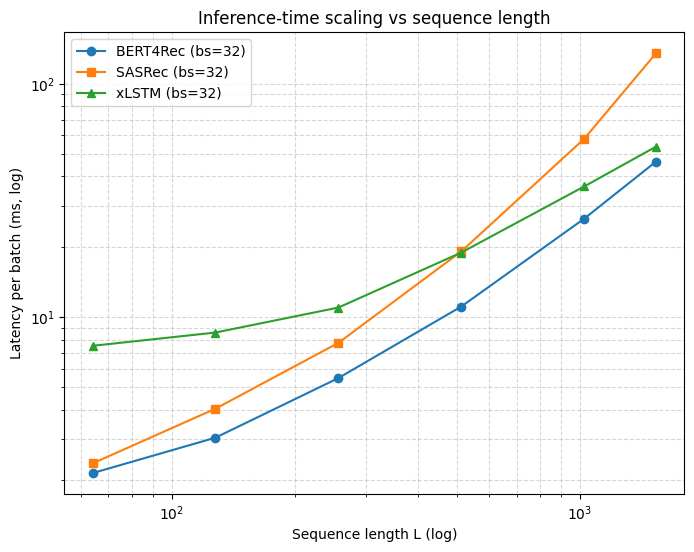


Estimated scaling exponent (alpha) from log–log fit (batch = 32):
  BERT4Rec      alpha ≈ 0.98  (1≈linear, 2≈quadratic)
  SASRec        alpha ≈ 1.26  (1≈linear, 2≈quadratic)
  xLSTM         alpha ≈ 0.64  (1≈linear, 2≈quadratic)


In [18]:
import time, math, torch, numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# --------- constants from your checkpoints ---------
VOCAB = 10678        # items incl. padding id 0
EMB_DIM = 256
MAX_TEST_L = 1536
BATCHES = [32]
# SEQ_LENS = [10, 25, 50, 100, 200, 400]
SEQ_LENS = [64, 128, 256, 512, 1024, 1536]

WARMUP = 10
REPEATS = 60

import torch.nn as nn

class TinyBERT4Rec(nn.Module):
    def __init__(self, vocab_size, d_model=EMB_DIM, nhead=8, nlayers=4, max_len=MAX_TEST_L):
        super().__init__()
        self.item_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_emb  = nn.Embedding(max_len, d_model)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
                                           batch_first=True)
        self.enc = nn.TransformerEncoder(layer, num_layers=nlayers)
        self.norm = nn.LayerNorm(d_model)
        self.out  = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        B,T = x.shape
        pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B,T)
        h = self.item_emb(x) + self.pos_emb(pos)
        h = self.enc(h)  # bidirectional (no causal mask)
        h = self.norm(h[:, -1, :])
        return self.out(h)

class TinySASRec(nn.Module):
    def __init__(self, vocab_size, d_model=EMB_DIM, nhead=8, nlayers=4, max_len=MAX_TEST_L):
        super().__init__()
        self.item_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_emb  = nn.Embedding(max_len, d_model)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
                                           batch_first=True)
        self.enc = nn.TransformerEncoder(layer, num_layers=nlayers)
        self.out  = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        B,T = x.shape
        pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B,T)
        h = self.item_emb(x) + self.pos_emb(pos)
        attn_mask = torch.triu(torch.full((T,T), float("-inf"), device=x.device), diagonal=1)  # causal
        key_pad = (x==0)  # padding mask
        h = self.enc(h, mask=attn_mask, src_key_padding_mask=key_pad)
        return self.out(h[:, -1, :])

class TinyLSTM(nn.Module):
    def __init__(self, vocab_size, d_model=EMB_DIM, nlayers=1):
        super().__init__()
        self.item_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.lstm = nn.LSTM(d_model, d_model, num_layers=nlayers, batch_first=True)
        self.out  = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        h,_ = self.lstm(self.item_emb(x))
        return self.out(h[:, -1, :])

def safe_load(sd, key):
    w = sd.get(key, None)
    if w is None:
        for k in sd.keys():
            if k.endswith(key) or key in k:
                return sd[k]
    return w

def load_models():
    # BERT4Rec
    bert = TinyBERT4Rec(VOCAB).to(DEVICE)
    sd_bert = torch.load("best_model_10M_BERT4Rec_SL_100_Emb_256.pt", map_location="cpu")
    w = safe_load(sd_bert, "bert.embeddings.word_embeddings.weight")
    if w is not None and w.shape[1]==EMB_DIM:
        with torch.no_grad():
            bert.item_emb.weight[:w.shape[0]].copy_(w)

    # SASRec
    sas = TinySASRec(VOCAB).to(DEVICE)
    sd_sas = torch.load("best_model_10M_SAS4Rec_SL_128_Emb_256_seed_2023.pt", map_location="cpu")
    w = safe_load(sd_sas, "item_embedding.weight")
    if w is not None and w.shape[1]==EMB_DIM:
        with torch.no_grad():
            sas.item_emb.weight[:w.shape[0]].copy_(w)

    # xLSTM fallback: simple LSTM proxy (linear scaling)
    try:
        from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge
        cfg = xLSTMLargeConfig(embedding_dim=EMB_DIM, num_heads=8, num_blocks=4,
                               vocab_size=VOCAB, return_last_states=True, mode="train")
        xl = xLSTMLarge(cfg).to(DEVICE)
        sd_x = torch.load("best_model_10M_xLSTM_SL_100_Emb_256.pt", map_location="cpu")
        xl.load_state_dict(sd_x, strict=False)
        model_x = xl
        x_name = "xLSTM"
    except Exception as e:
        print("⚠️ xLSTM package not found, using LSTM proxy:", e)
        xl = TinyLSTM(VOCAB).to(DEVICE)
        sd_x = torch.load("best_model_10M_xLSTM_SL_100_Emb_256.pt", map_location="cpu")
        w = safe_load(sd_x, "embedding.weight")
        if w is not None and w.shape[1]==EMB_DIM:
            with torch.no_grad():
                xl.item_emb.weight[:w.shape[0]].copy_(w)
        model_x = xl
        x_name = "LSTM proxy"
    return {"BERT4Rec": bert.eval(), "SASRec": sas.eval(), x_name: model_x.eval()}

models = load_models()
for k in models: print("Loaded:", k)

@torch.inference_mode()
def time_model(model, batch, T, repeats=REPEATS, warmup=WARMUP):
    # Integer item IDs in [1, VOCAB) (0 is padding)
    x = torch.randint(low=1, high=VOCAB, size=(batch, T), device=DEVICE, dtype=torch.long)

    # warmup
    for _ in range(warmup):
        _ = model(x)
        if DEVICE.type=='cuda': torch.cuda.synchronize()

    # measured
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = model(x)
        if DEVICE.type=='cuda': torch.cuda.synchronize()
        t1 = time.perf_counter()
        times.append((t1 - t0)*1000.0)  # ms

    ms = mean(times)
    sd = stdev(times) if len(times)>1 else 0.0
    tok = batch*T
    tps = tok / (ms/1000.0)  # tokens/sec
    return {"mean_ms": ms, "std_ms": sd, "throughput_tok_s": tps}

rows = []
for name, model in models.items():
    for bs in BATCHES:
        for L in SEQ_LENS:
            m = time_model(model, bs, L)
            rows.append({"model": name, "batch": bs, "L": L, **m})
            print(f"{name:12s} | bs={bs:3d} L={L:4d}  mean={m['mean_ms']:.2f} ms  ±{m['std_ms']:.2f}   tok/s={m['throughput_tok_s']:.0f}")

# ---- Plot (latency vs L) and fit exponent ----
import pandas as pd
df = pd.DataFrame(rows)

plt.figure(figsize=(8,6))
markers = {"BERT4Rec":"o","SASRec":"s","xLSTM":"^","LSTM proxy":"^"}
for name in df.model.unique():
    dd = df[(df.model==name) & (df.batch==BATCHES[0])]
    plt.plot(dd["L"], dd["mean_ms"], marker=markers.get(name,"o"), label=f"{name} (bs={BATCHES[0]})")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Sequence length L (log)")
plt.ylabel("Latency per batch (ms, log)")
plt.title("Inference-time scaling vs sequence length")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()

def fit_alpha(dd):
    x = np.log(dd["L"].values.astype(float))
    y = np.log(dd["mean_ms"].values.astype(float))
    a, b = np.polyfit(x, y, 1)   # y ≈ a*x + b
    return a

print("\nEstimated scaling exponent (alpha) from log–log fit (batch = %d):" % BATCHES[0])
for name in df.model.unique():
    dd = df[(df.model==name) & (df.batch==BATCHES[0])]
    alpha = fit_alpha(dd)
    print(f"  {name:12s}  alpha ≈ {alpha:.2f}  (1≈linear, 2≈quadratic)")